In [53]:
#importing necessary packages
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import random
import math
from collections import Counter

### Loading the Data

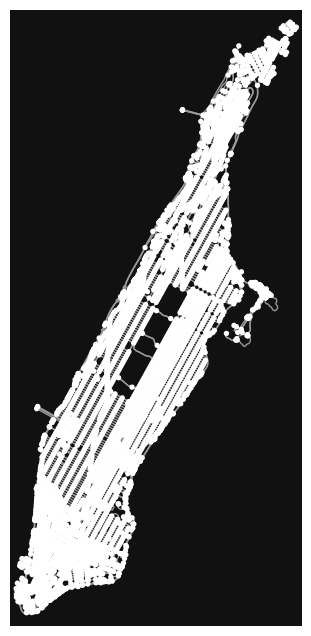

In [4]:
#Dowloading the Manhattan street network and doing a preliminary plot
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)

In [5]:
#Loading the data with the firehouse coordinates
firehouse_listing = pd.read_csv("FDNY_Firehouse_Listing_20250401.csv")

In [6]:
#Extracting the information of Manhattan fire stations only
manhattan_firestations = firehouse_listing[firehouse_listing["Borough"] == "Manhattan"]
manhattan_firestations

FacilityName  \
0                                  Engine 4/Ladder 15   
1                                            Engine 6   
2   Manhattan Borough Command/Battalion 1/Engine 7...   
3                                            Ladder 8   
4                                   Engine 9/Ladder 6   
5                     Battalion 4/Engine 15/Ladder 18   
6                                 Engine 28/Ladder 11   
7                                            Engine 5   
8                                Division 1/Ladder 20   
9                                  Engine 33/Ladder 9   
10                               Battalion 6/Ladder 3   
11                                           Squad 18   
12                                Engine 34/Ladder 21   
13                                          Engine 26   
14                     Battalion 7/Engine 3/Ladder 12   
15                                 Engine 1/Ladder 24   
16                                          Engine 14   
17                                 Engine 16/Ladder 7   
18                                          Engine 21   
19                     Battalion 9/Engine 54/Ladder 4   
20                                          Engine 23   
21                                Engine 40/Ladder 35   
22                               Division 3/Ladder 25   
23                                          Engine 74   
24                      Battalion 8/Engine 8/Ladder 2   
25                                          Engine 44   
26                   Battalion 10/Engine 22/Ladder 13   
27                                Engine 58/Ladder 26   
28                                Engine 53/Ladder 43   
29                                          Engine 91   
30                   Battalion 12/Engine 35/Ladder 14   
31                   Battalion 11/Engine 76/Ladder 22   
32                                          Engine 47   
33                                Engine 59/Ladder 30   
34                                Engine 37/Ladder 40   
35                                Engine 84/Ladder 34   
36                                Engine 95/Ladder 36   
37                                          Engine 55   
38                                           Rescue 1   
39                                Engine 39/Ladder 16   
40                   Battalion 16/Engine 69/Ladder 28   
41                                Engine 80/Ladder 23   
42                   Battalion 13/Engine 93/Ladder 45   
43                                Engine 10/Ladder 10   
44                                          Engine 65   
45                     Battalion 2/Engine 24/Ladder 5   
46                                          Engine 67   
47                                           Marine 1   

              FacilityAddress    Borough  Postcode   Latitude  Longitude  \
0             42 South Street  Manhattan     10005  40.703694 -74.007717   
1           49 Beekman Street  Manhattan     10038  40.709971 -74.005395   
2            100 Duane Street  Manhattan     10007  40.715339 -74.006300   
3          14 N. Moore Street  Manhattan     10013  40.719574 -74.006620   
4             75 Canal Street  Manhattan     10002  40.715408 -73.992834   
5              25 Pitt Street  Manhattan     10002  40.716439 -73.983927   
6           222 East 2 Street  Manhattan     10009  40.721879 -73.982526   
7          340 East 14 Street  Manhattan     10003  40.731494 -73.983407   
8        253 Lafayette Street  Manhattan     10012  40.723026 -73.996571   
9       42 Great Jones Street  Manhattan     10012  40.726986 -73.992526   
10         108 East 13 Street  Manhattan     10003  40.733093 -73.989443   
11         132 West 10 Street  Manhattan     10014  40.734518 -74.000381   
12       440 West 38th Street  Manhattan     10018  40.756593 -73.996471   
13         220 West 37 Street  Manhattan     10018  40.753107 -73.990376   
14         150 West 19 Street  Manhattan     10011  40.741196 -73.996868   
15         142 West 31 Street  

In [7]:
#converting graph to projected form - enables easier data handling, especially for compatability with the pandas dataframe
G_proj = ox.project_graph(G)

In [8]:
#converting the fire station dataframe to geodataframe
geometry = [Point(xy) for xy in zip(manhattan_firestations["Longitude"], manhattan_firestations["Latitude"])]
gdf_firestations = gpd.GeoDataFrame(manhattan_firestations, geometry=geometry, crs="EPSG:4326")

#projecting to the same as the projection graph
gdf_firestations_proj = gdf_firestations.to_crs(G_proj.graph['crs'])

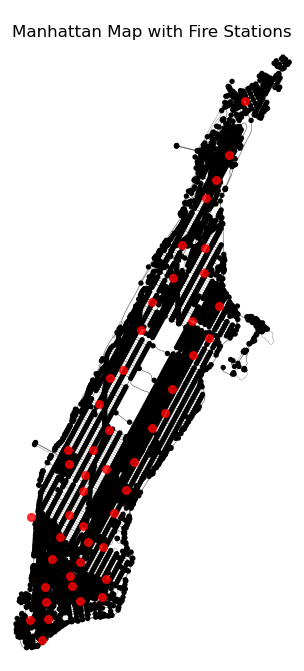

In [9]:
#plotting the graph with fire stations
fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor="white", edge_color="black", edge_alpha=0.5, 
                        node_color="black", edge_linewidth=0.3)
gdf_firestations_proj.plot(ax=ax, color='red', markersize=30, alpha=0.8, zorder=3)
plt.title("Manhattan Map with Fire Stations")
plt.show()

Here, we are just overlaying the location of the fire stations on the map. The fire stations are not nodes yet. The next step is to map the fire stations onto actual nodes of the graph.

### Constructing the graph

Constructing a weighted graph:

In [10]:
G_weighted = nx.DiGraph() #directed because streets have directions (e.g. one way streets) and weighted because of their lengths

#adding the edges from the projected graph to the new graph
for u, v, data in G_proj.edges(data=True):
    weight = data.get('length', 1) #defaults to 1 if the length is missing
    G_weighted.add_edge(u, v, weight=weight)

#adding the nodes from the projected graph to the new graph
for node, data in G_proj.nodes(data=True):
    G_weighted.add_node(node, **data)

Finding the nearest node in the graph to represent each firehouse (ensures every firehouse is actually at an acceptable/valid point on the map)

In [11]:
firehouse_nodes = ox.distance.nearest_nodes(
    G_proj,
    X=gdf_firestations_proj.geometry.x,
    Y=gdf_firestations_proj.geometry.y
)

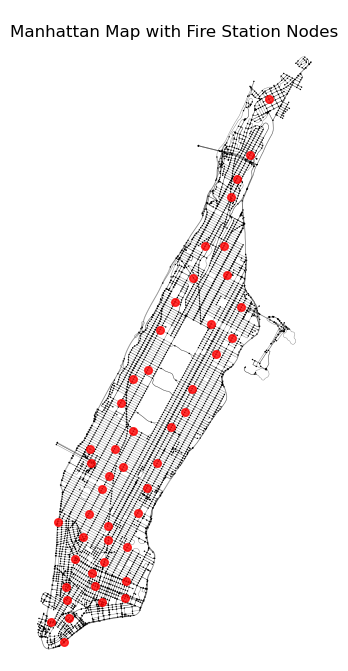

In [12]:
#plotting the ACTUAL fire station nodes:
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[node][0] for node in firehouse_nodes]
firehouse_y = [node_positions[node][1] for node in firehouse_nodes]

fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor='white',
                        edge_color='black', edge_alpha=0.5,
                        node_color='black', node_size=1,
                        edge_linewidth=0.3)
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, alpha=0.8, zorder=3, label='Firehouse')
plt.title("Manhattan Map with Fire Station Nodes")
plt.show()

### Simulating an Emergency

Choosing 3 distinct emergency locations and compute the minimum response time from the closest fire station.

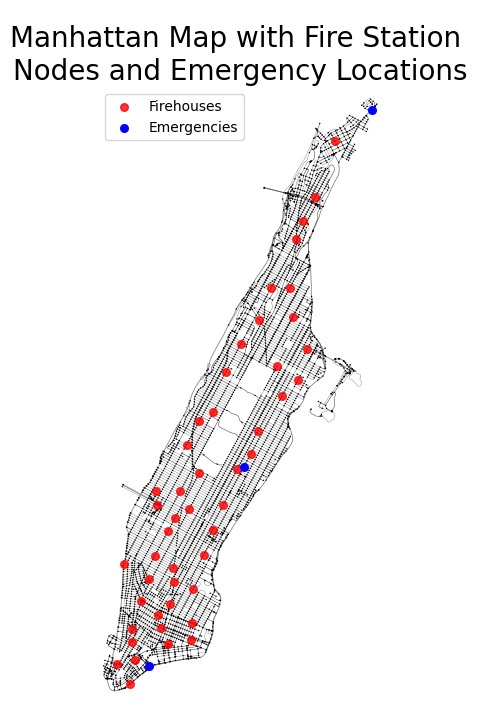

In [13]:
#we choose 3 nodes at random
random.seed(3) #for reproducibility
emergency_nodes = random.sample(list(G_weighted.nodes), 3) #choose 3 nodes

#plotting these 3 nodes onto the Manhattan map
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[node][0] for node in firehouse_nodes] #firehouse coordinates
firehouse_y = [node_positions[node][1] for node in firehouse_nodes]
emergency_x = [node_positions[node][0] for node in emergency_nodes] #emergency coordinates
emergency_y = [node_positions[node][1] for node in emergency_nodes]

fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor='white',
                        edge_color='black', edge_alpha=0.5,
                        node_color='black', node_size=1,
                        edge_linewidth=0.3)
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, alpha=0.8, zorder=3, label='Firehouses')
ax.scatter(emergency_x, emergency_y, c='blue', s=30, zorder=3, label='Emergencies')
plt.title("Manhattan Map with Fire Station \nNodes and Emergency Locations", size = 20)
ax.legend()
plt.show()

### Dijkstra's Algorithm

Now, we can apply shortest path algorithms (Dijkstra's and A-star) to calculate the minimum distance from the firehouses to the emergency location.

We begin by using Dijkstra's algorithm (we have positive path lengths only, so we can use this algorithm)

In [14]:
#initializing lists
length_paths = []
length_distances = []

for emergency in emergency_nodes: #for loop that computes the path for each emergency node
    min_distance = float("inf") #initializing values that will be updated
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes: #for loop that goes through all of the firehouses to see which is the closest, and storing its path
        try:
            distance, path = nx.single_source_dijkstra(G_proj, source = firehouse, target=emergency, weight = "length") #here we use the Dijkstra algorithm
            if distance < min_distance: #updating values if the distance is smaller than the current minimum
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath: #if there is no path, continue looking
            continue
    
    if best_path is not None: #if we have found a best path
        length_paths.append(best_path) #we append that best path to the list
    if min_distance is not float("inf"): 
        length_distances.append(min_distance) #we append the minimum distance to the list

print(len(length_paths)) #this should be 3 because we have 3 emergency nodes
print(length_paths)
print(length_distances)


3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[608.8185127851767, 917.7797061705894, 1712.590888141085]


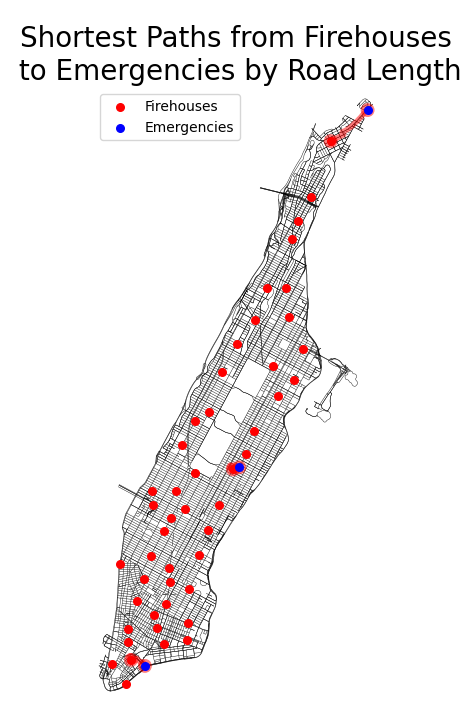

In [15]:
#plotting the graph with the paths
fig, ax = ox.plot_graph_routes(G_proj, routes=length_paths, route_color='blue', route_linewidth=2, node_size=0, bgcolor='white', show=False, close=False, edge_color='black', edge_linewidth=0.3)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[n][0] for n in firehouse_nodes]
firehouse_y = [node_positions[n][1] for n in firehouse_nodes]
emergency_x = [node_positions[n][0] for n in emergency_nodes]
emergency_y = [node_positions[n][1] for n in emergency_nodes]
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, label='Firehouses', zorder=3)
ax.scatter(emergency_x, emergency_y, c='blue', s=30, label='Emergencies', zorder=3)
plt.title("Shortest Paths from Firehouses\n to Emergencies by Road Length", size = 20)
ax.legend(loc="upper left")
plt.show()

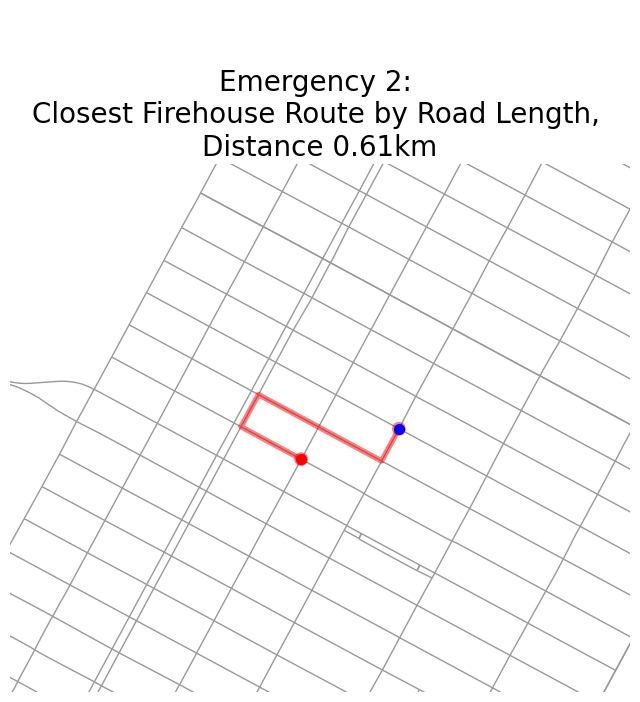

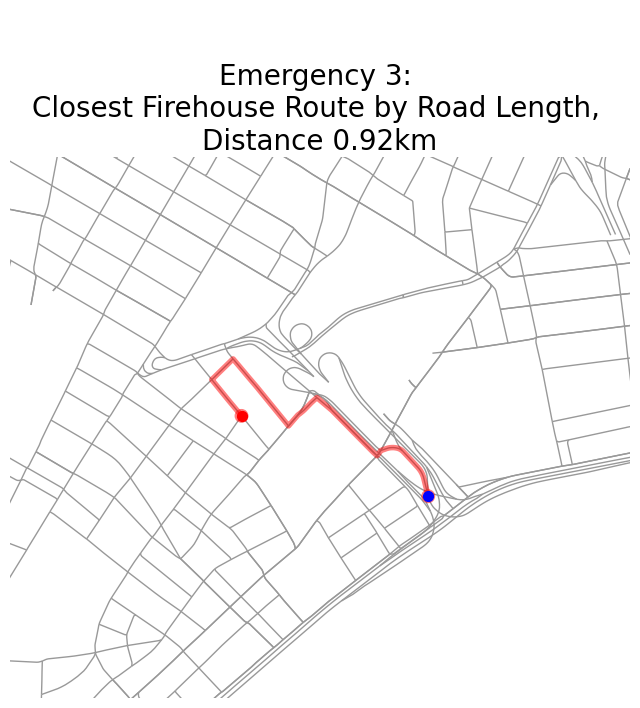

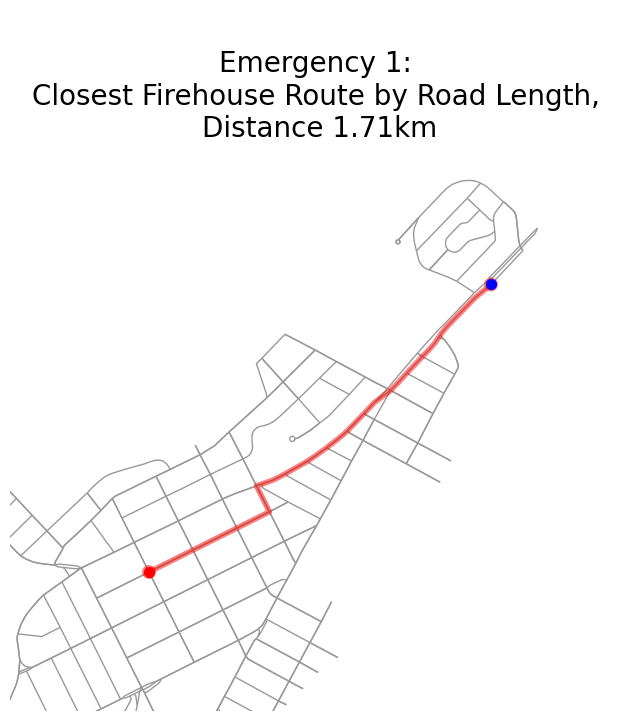

In [ ]:
#we want to zoom in to visualize the paths better:

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

#loop through the paths and plot them one by one
for idx, path in enumerate(length_paths):
    emergency_node = path[-1] #the emergency node is always the end of the path
    firehouse_node = path[0] #the firehouse node is always the start of the path

    path_x = [node_positions[n][0] for n in path] #extracting the x coordinates of the path
    path_y = [node_positions[n][1] for n in path] #extracting the y coordinates of the path

    #setting a margin around the path that we will zoom into
    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2: \nClosest Firehouse Route by Road Length, \nDistance {round(length_distances[idx]/1000, 2)}km", size = 20)
    elif idx == 1:
        ax.set_title(f"Emergency 3: \nClosest Firehouse Route by Road Length, \nDistance {round(length_distances[idx]/1000, 2)}km", size = 20)
    else:
        ax.set_title(f"Emergency 1: \nClosest Firehouse Route by Road Length, \nDistance {round(length_distances[idx]/1000, 2)}km", size = 20)
    ax.legend(fontsize = 20, loc = "upper left")
    plt.show()


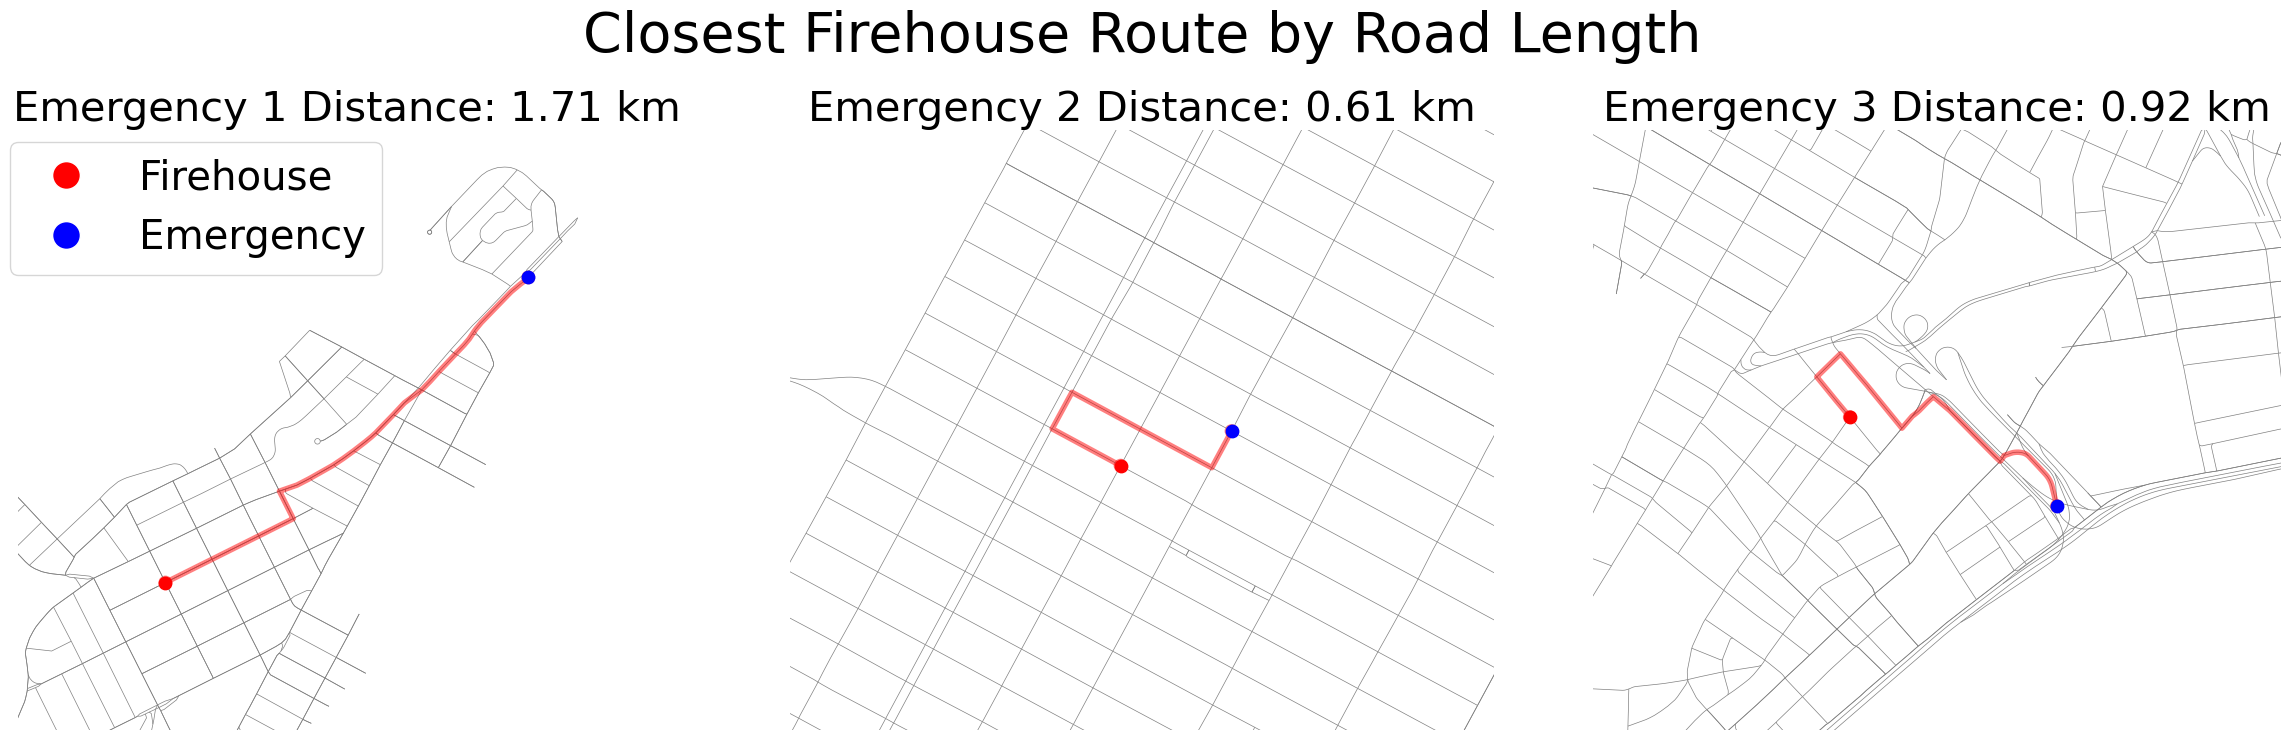

In [115]:
# Desired order: Emergency 1, Emergency 2, Emergency 3
desired_order = [2, 0, 1]  # indices in length_paths

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
fig.suptitle("Closest Firehouse Route by Road Length", fontsize=40, y=1)

titles = [
    "Emergency 1",
    "Emergency 2",
    "Emergency 3"
]

for plot_idx, path_idx in enumerate(desired_order):
    path = length_paths[path_idx]
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    ax = axes[plot_idx]

    # Plot route first so it stays on top of roads
    ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False,
        ax=ax
    )

    # Plot background road network
    ox.plot_graph(
        G_proj,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False,
        bgcolor='white'
    )

    # Mark firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=80, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=80, zorder=3, label='Emergency')

    # Zoom to route
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"{titles[plot_idx]} Distance: {round(length_distances[path_idx]/1000, 2)} km", fontsize=30)

# Shared legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Firehouse',
           markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Emergency',
           markerfacecolor='blue', markersize=20)
]

# Place the legend below the plots
fig.legend(handles=legend_handles, loc='upper left', fontsize=29, bbox_to_anchor=(0.02, 0.86))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust spacing for title and legend
plt.show()


Comments:

The first one looks unneccessarily long, but this can happen because:
* OSMnx (the library used) uses actual physical distances, and the route it chose could be the one that minimzes the length (the map might be misleading)
* OSMnx takes into account one-way streets - it could be that the street that "looks shorter" cannot be travelled on because it is a one way street.

In [ ]:
#visualizing what attributes the edges have:
firehouse_node = 42437433 #just an example node
list(G_proj.out_edges(firehouse_node, data=True)) #we look at the attributes of the edges that are outgoing from the firehouse node

[(42437433,
  42437428,
  {'osmid': 945384088,
   'highway': 'residential',
   'maxspeed': '25 mph',
   'name': 'East 67th Street',
   'oneway': True,
   'reversed': False,
   'length': 147.93177529759768,
   'geometry': <LINESTRING (587390.853 4513434.842, 587381.797 4513439.776, 587366.973 4513...>,
   'lanes': '1'}),
 (42437433,
  42447069,
  {'osmid': 945384089,
   'highway': 'secondary',
   'name': 'Lexington Avenue',
   'oneway': True,
   'reversed': False,
   'length': 79.61733899261314,
   'geometry': <LINESTRING (587390.853 4513434.842, 587387.54 4513428.752, 587356.094 45133...>,
   'lanes': '2'})]

We do therefore see that both are actually one-way streets and therefore this could be why the route that looks the shortest is not taken.

#### A-star

This is just a side note / bonus. We do not use A* as the main algorithm throughout the notebook, but here we looked at whether using A* was going to be beneficial or whether it was just going to be the same as Dijkstra's.

First, we will simply use the euclidean distance as the heuristic.

3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[608.8185127851767, 917.7797061705894, 1712.590888141085]


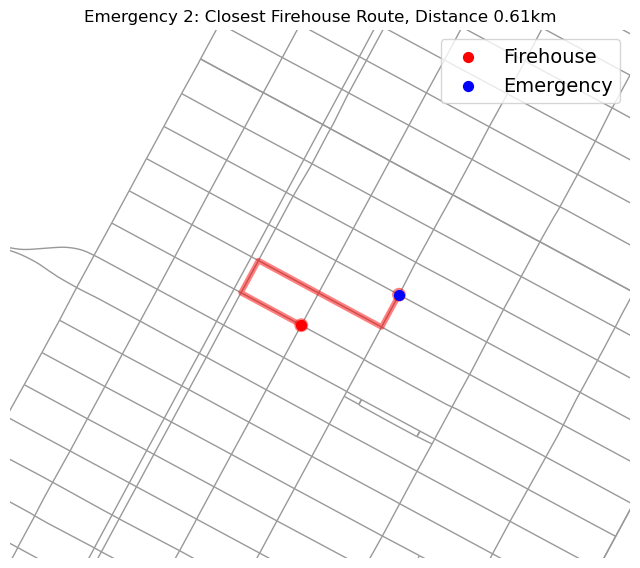

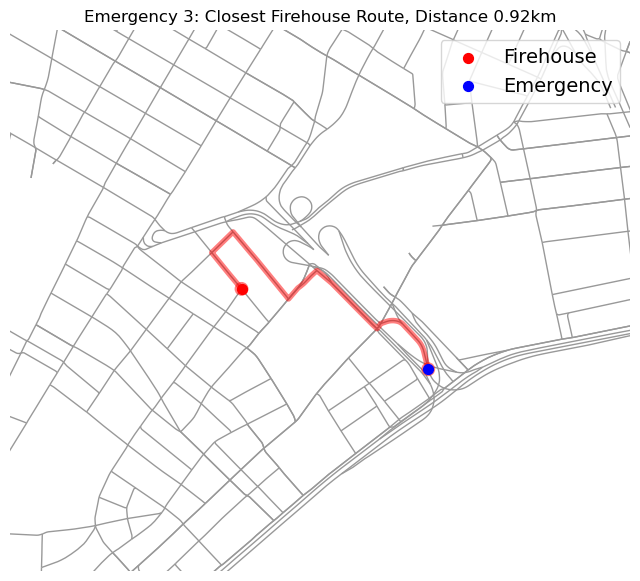

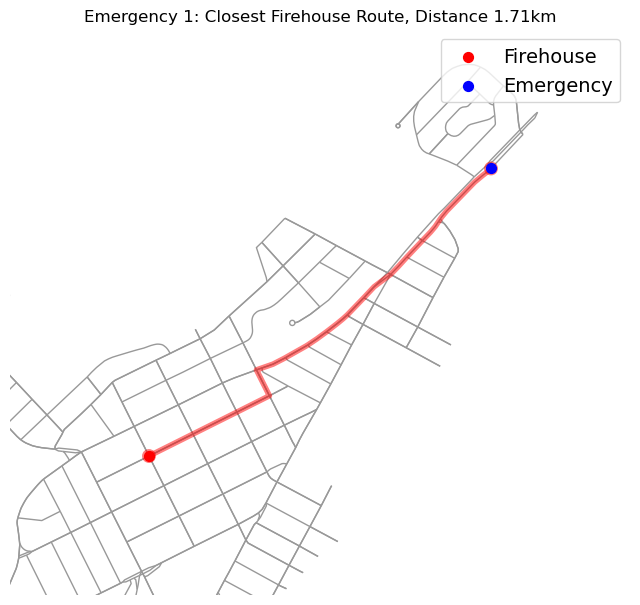

In [77]:
#defining the heuristic function for A* algorithm
#this function computes the Euclidean distance between two nodes
def euclidean_heuristic(u, v):
    ux, uy = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
    vx, vy = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
    return math.hypot(ux - vx, uy - vy)

a_paths = [] #initializing lists for storing the paths and distances
a_distances = []

#this setup is similar to the Dijkstra algorithm, but we use the A* algorithm instead
for emergency in emergency_nodes: 
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            path = nx.astar_path(G_proj, source=firehouse, target=emergency, heuristic=euclidean_heuristic, weight='length') #here, we use A*
            distance = nx.path_weight(G_proj, path, weight = "length")
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        a_paths.append(best_path)
    if min_distance is not float("inf"):
        a_distances.append(min_distance)

print(len(a_paths)) #this should be 3 because we have 3 emergency nodes
print(a_paths)
print(a_distances)

#plotting (exactly the same as before)
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
for idx, path in enumerate(a_paths):
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2: Closest Firehouse Route, Distance {round(a_distances[idx]/1000, 2)}km")
    elif idx == 1:
        ax.set_title(f"Emergency 3: Closest Firehouse Route, Distance {round(a_distances[idx]/1000, 2)}km")
    else:
        ax.set_title(f"Emergency 1: Closest Firehouse Route, Distance {round(a_distances[idx]/1000, 2)}km")
    
    ax.legend(fontsize = 14)
    plt.show()


We see that A* and Dijkstras paths do not change, they find the same paths (as expected). There was also no difference in computational complexity, since our graph is not incredibly large, and therefore from now on we will use Dijkstra's algorithm and not A*.

### Shortest Paths by Travel Time

So far, we computed shortest paths using the length, but in emergency scenarios, travel time is also crucial. We therefore now use the travel time, assuming that the max speed attribute of the edges is the speed that the cars go in.

In [20]:
G_proj = ox.add_edge_speeds(G_proj) #estimates speed based on the highway types

In [21]:
G_proj = ox.add_edge_travel_times(G_proj) #adds the travel time in seconds based on speed and length

In [33]:
#now we compute the shortest paths based on the travel times and see if anything changes

#code is exactly the same as before, but we use travel time as the weight.
time_paths = []
time_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(G_proj, source = firehouse, target=emergency, weight = "travel_time") #specifies using travel time as the weight
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        time_paths.append(best_path)
    if min_distance is not float("inf"):
        time_distances.append(min_distance)

print(len(time_paths))
print(time_paths)
print(type(time_paths))
print(time_distances)

3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
<class 'list'>
[56.4406586649332, 98.40352710607725, 158.63651330818186]


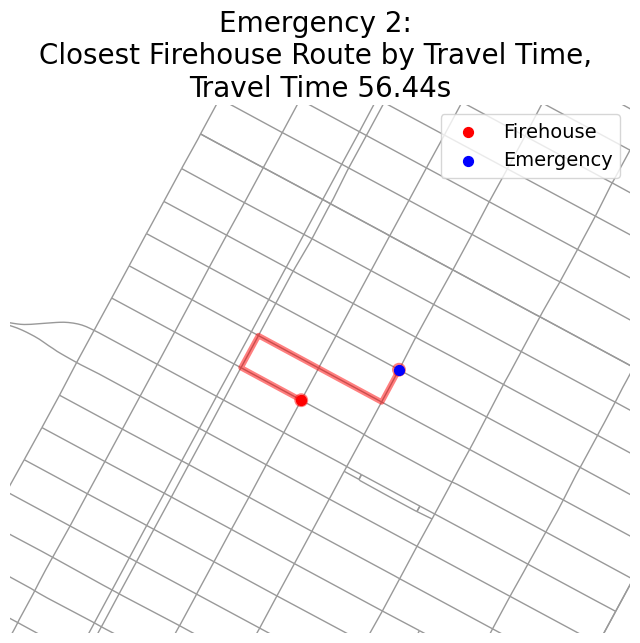

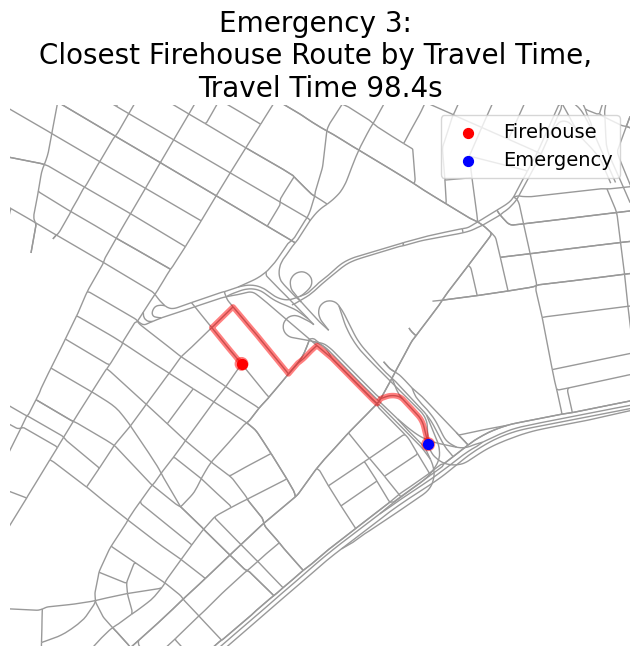

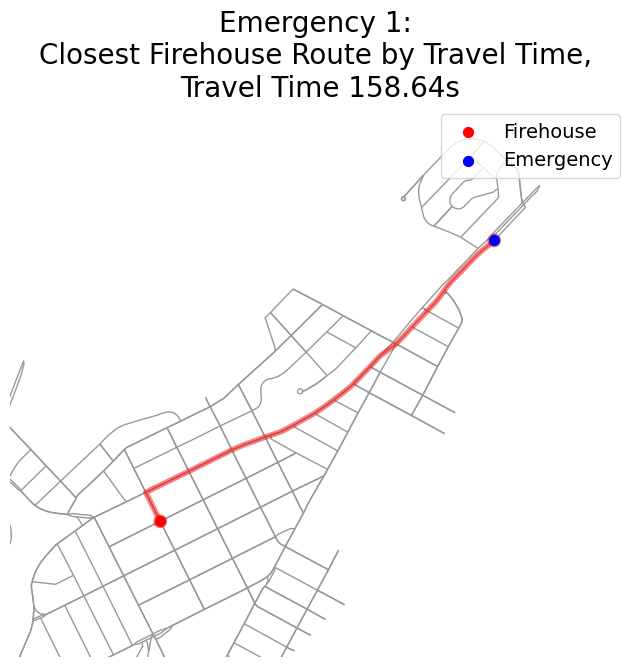

In [78]:
#plotting (same code as above)
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, time_path in enumerate(time_paths):
    emergency_node = time_path[-1]
    firehouse_node = time_path[0]

    path_x = [node_positions[n][0] for n in time_path]
    path_y = [node_positions[n][1] for n in time_path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[time_path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2: \nClosest Firehouse Route by Travel Time, \nTravel Time {round(time_distances[idx], 2)}s", size = 20)
    elif idx == 1:
        ax.set_title(f"Emergency 3: \nClosest Firehouse Route by Travel Time, \nTravel Time {round(time_distances[idx], 2)}s", size = 20)
    else:
        ax.set_title(f"Emergency 1: \nClosest Firehouse Route by Travel Time, \nTravel Time {round(time_distances[idx], 2)}s", size = 20)

    ax.legend(fontsize=14)
    plt.show()

These remained mostly similar, except for the third which changed.

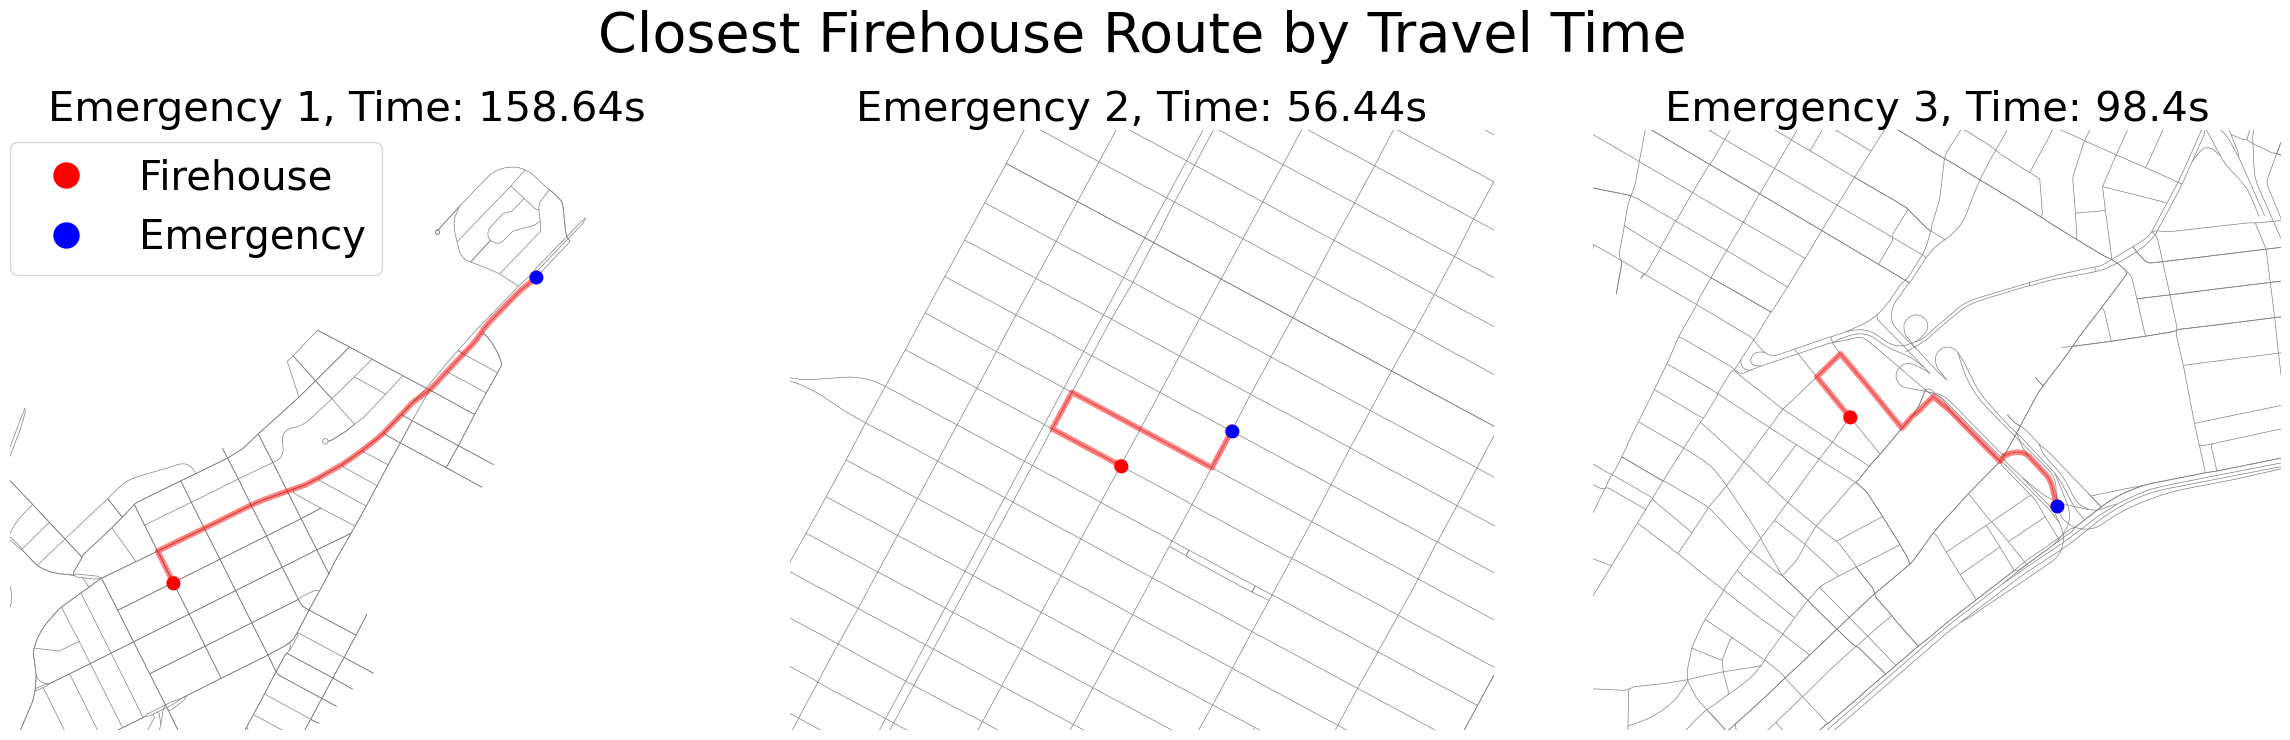

In [118]:
# Desired order: Emergency 1, Emergency 2, Emergency 3
desired_order = [2, 0, 1]  # indices in time_paths

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
fig.suptitle("Closest Firehouse Route by Travel Time", fontsize=40, y=1)

titles = [
    "Emergency 1",
    "Emergency 2",
    "Emergency 3"
]

for plot_idx, path_idx in enumerate(desired_order):
    path = time_paths[path_idx]
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    ax = axes[plot_idx]

    # Plot route first so it stays on top of roads
    ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False,
        ax=ax
    )

    # Plot background road network 
    ox.plot_graph(
        G_proj,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False,
        bgcolor='white'
    )

    # Mark firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=80, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=80, zorder=3, label='Emergency')

    # Zoom to route
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"{titles[plot_idx]}, Time: {round(time_distances[path_idx], 2)}s", fontsize=30)

# Shared legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Firehouse',
           markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Emergency',
           markerfacecolor='blue', markersize=20)
]

# Place the legend below the plots
fig.legend(handles=legend_handles, loc='upper left', fontsize=29, bbox_to_anchor=(0.02, 0.86))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust spacing for title and legend
plt.show()


Why did the third path change?

In [35]:
length_path_3 = length_paths[2] #selecting the third path from the road length weight
time_path_3 = time_paths[2] #selecting the third path from the travel time weight
print(time_paths)

print("Length-based path:", length_path_3)
print("Time-based path:", time_path_3)

#function to extract edge information
def get_edge_info(path):
    """
    This function takes a path and returns a list of dictionaries with edge information.
    """
    edge_info = []
    for u, v in zip(path[:-1], path[1:]): #pairing the nodes in the path
        data = G_proj.get_edge_data(u, v) #extracting the edge data
        edge_info.append({
            "from": u,
            "to": v,
            "length": data[0].get("length"),
            "travel_time": data[0].get("travel_time"),
            "highway": data[0].get("highway"),
            "name": data[0].get("name")
        }) #appending the edge information to the list
    return edge_info

info_length = get_edge_info(length_path_3) #extracting edge information for the length-based path
info_time = get_edge_info(time_path_3) #extracting edge information for the time-based path


print("Length-based")
print(pd.DataFrame(info_length))
print("Time-based")
print(pd.DataFrame(info_time))


[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
Length-based path: [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]
Time-based path: [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]
Length-based
          from          to      length  travel_time   highway  \
0     42437921    42437923  176.691975    17.421730  tertiary   
1     42437923    42431242  176.417677    17.394684  tertiary   
2     42

We can now see that the third path in the time based paths uses more primary highways than the third path in the road length paths. This is likely because primary highways are the larger highways and therefore they allow cars to go faster on them, reducing the travel time.

### Narrow/Slow Roads

We have the number of lanes each road (edge) has, so we can use less lanes as a penalty, where the less lanes there are the slower it is to use that road.

In [36]:
#we need to define a function that computes the weight based on the number of lanes
#we need to define this function because the default weight function in networkx does not take into account the number of lanes
#so we create a custom weight function that penalizes roads with fewer lanes that is compatible with networkx
def compute_penalized_weight(data):
    """
    Computes a weight that penalizes roads that have less lanes
    """
    try:
        lanes_value = data.get("lanes", 1) #if there are no lanes, we default to 1 lane.
        if isinstance(lanes_value, list): #if there are multiple values, we take the average of the lanes
            lanes = sum(float(l) for l in lanes_value if str(l).isdigit()) / len(lanes_value)
        else:
            lanes = float(lanes_value) #if there is only one value, we take that value

        travel_time = data.get("travel_time", 1) #if there is no travel time, we default to 1 second
        if isinstance(travel_time, list): #if there are multiple values, we take the first value in the list
            travel_time = float(travel_time[0])
        else:
            travel_time = float(travel_time)

        return travel_time * (1 + (1 / lanes)) #this is the penalization factor. 
        #the less lanes, the higher we want the weight to be. we add 1 as we want to penalize the weights upwards, not downwards, as 1/lanes <= 1 but 1 + 1/lanes >= 1.

    except (KeyError, ZeroDivisionError, ValueError, TypeError) as e: #catching errors that may occur if the data is not in the expected format
        print(f"Skipping edge due to error: {e}")
        return float("inf")

In [ ]:
#we need to add the penalized weight to the edges of the graph as an attribute.
for u, v, data in G_proj.edges(data=True):
    try:
        data["penalized_weight"] = compute_penalized_weight(data)
    except KeyError: #catching errors that may occur if the data is not in the expected format
        data["penalized_weight"] = float("inf")  #if "length" is missing


[[42437433, 42447069, 42447060, 42449985, 5542680310, 42447235, 42437436, 42431680, 42449991], [42421951, 42421946, 42421941, 42453902, 42429844, 42454798, 42427251, 42440350, 42440270, 42444271, 42433229, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[77.23097810176326, 182.85446495703795, 217.15199506537533]


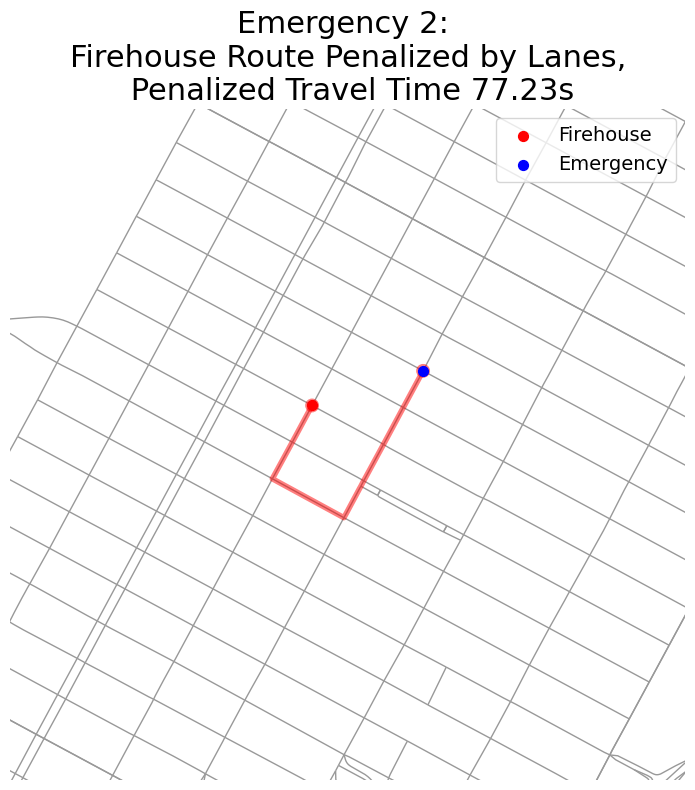

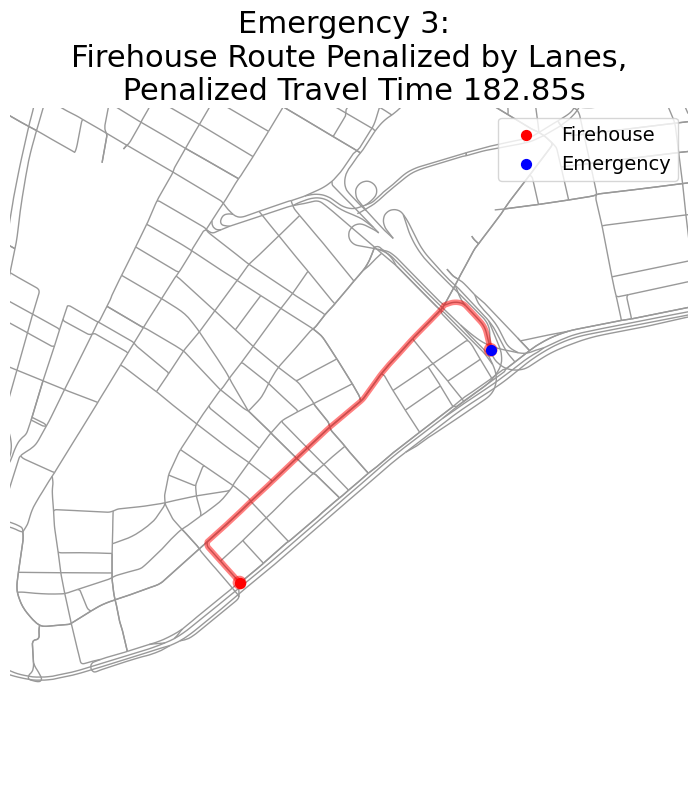

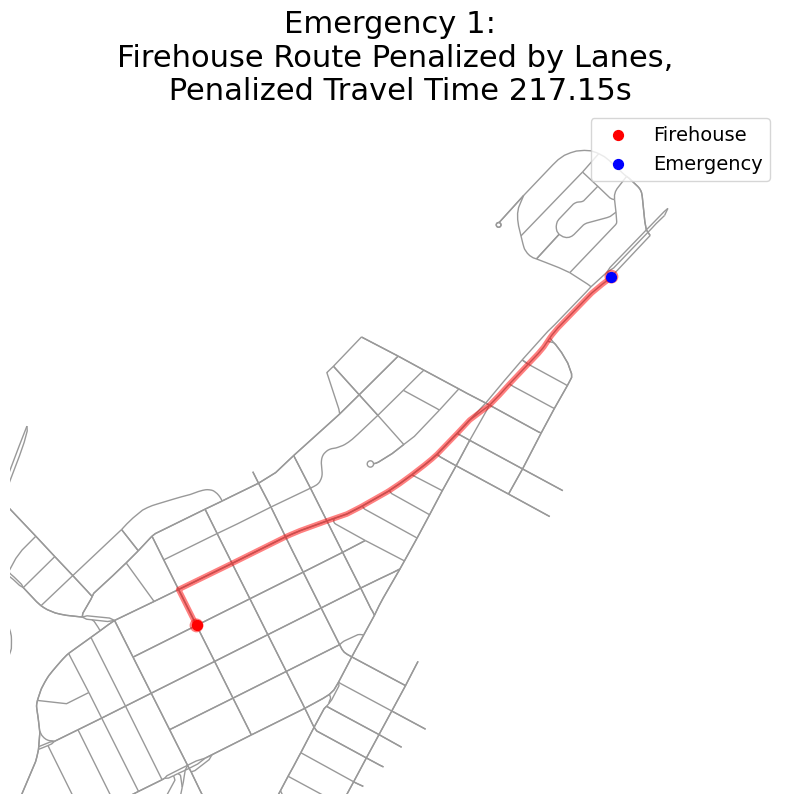

In [79]:
#here, we apply dijkstra's algorithm to find the shortest path based on the penalized weight.
#this code is similar to the previous ones, but we use the lanes penalized weight as the weight.
lane_paths = []
lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="penalized_weight") #lanes penalized weight
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        lane_paths.append(best_path)
    if min_distance is not float("inf"):
        lane_distances.append(min_distance)

print(lane_paths)
print(lane_distances)

#plotting the graph with the paths
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2: \nFirehouse Route Penalized by Lanes,\n Penalized Travel Time {round(lane_distances[idx], 2)}s", fontsize = 22)

    elif idx == 1:
        ax.set_title(f"Emergency 3: \nFirehouse Route Penalized by Lanes,\n Penalized Travel Time {round(lane_distances[idx], 2)}s", fontsize = 22)
    else:
        ax.set_title(f"Emergency 1: \nFirehouse Route Penalized by Lanes,\n Penalized Travel Time {round(lane_distances[idx], 2)}s", fontsize = 22)
        
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


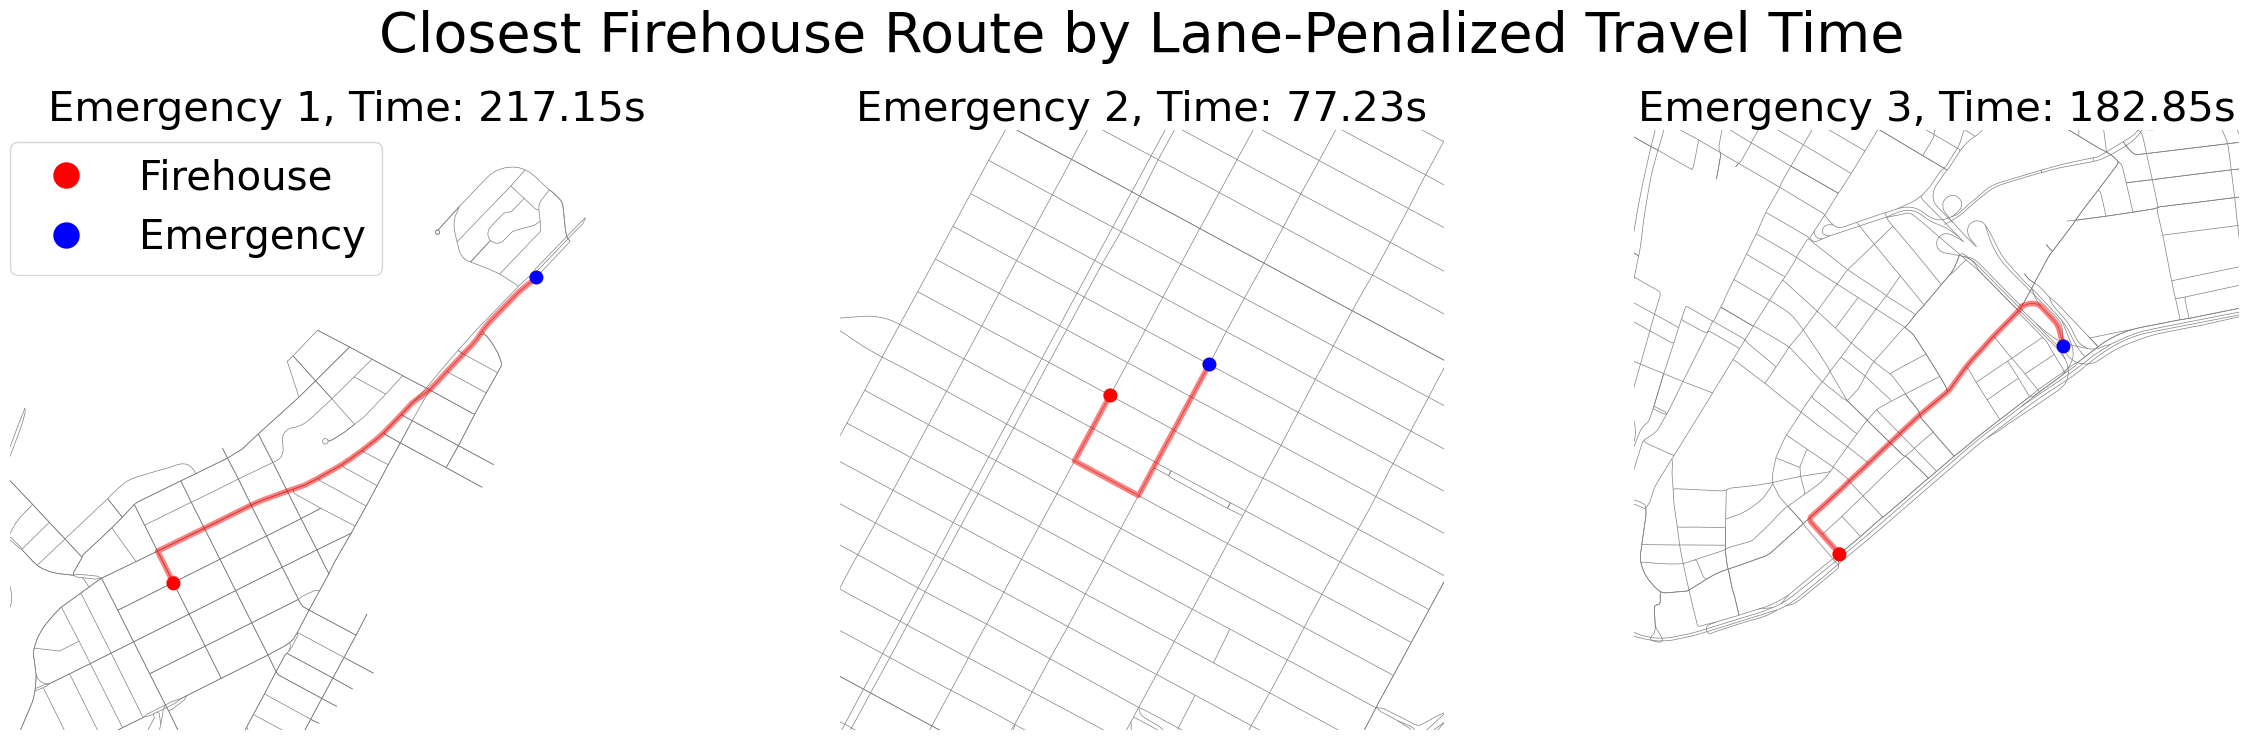

In [119]:
# Desired order: Emergency 1, Emergency 2, Emergency 3
desired_order = [2, 0, 1]  # indices in lane_paths

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
fig.suptitle("Closest Firehouse Route by Lane-Penalized Travel Time", fontsize=40, y=1)

titles = [
    "Emergency 1",
    "Emergency 2",
    "Emergency 3"
]

for plot_idx, path_idx in enumerate(desired_order):
    path = lane_paths[path_idx]
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    ax = axes[plot_idx]

    # Plot route first so it stays on top of roads
    ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False,
        ax=ax
    )

    # Plot background road network 
    ox.plot_graph(
        G_proj,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False,
        bgcolor='white'
    )

    # Mark firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=80, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=80, zorder=3, label='Emergency')

    # Zoom to route
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"{titles[plot_idx]}, Time: {round(lane_distances[path_idx], 2)}s", fontsize=30)

# Shared legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Firehouse',
           markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Emergency',
           markerfacecolor='blue', markersize=20)
]

# Place the legend below the plots
fig.legend(handles=legend_handles, loc='upper left', fontsize=29, bbox_to_anchor=(0.02, 0.86))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust spacing for title and legend
plt.show()


We need to be careful here, because this is not the actual time in seconds, but penalized time as it is the time multipled by a factor related to the lanes.

We can see that some of the paths have changed. We can look at the number of lanes that the edges in the paths have: 

In [40]:
#we want to extract the number of lanes for each edge in the path
lanes_list = [] #initializing the list
for idx, path in enumerate(lane_paths): #looping through the paths
    print(f"Path {idx+1} (Firehouse {path[0]} to Emergency {path[-1]}):") #printing the firehouse and emergency node
    lan = [] #initializing the list for the lanes
    for i in range(len(path) - 1): #looping through all edges and getting the edge data for each edge in the path
        u, v = path[i], path[i+1]
        edge_data = G_proj.get_edge_data(u, v) 

        if isinstance(edge_data, dict) and 0 in edge_data: 
            edge_data = edge_data[0]

        lanes = edge_data.get("lanes", "N/A") #if there are no lanes, we default to "N/A"
        print(f"  Edge ({u}, {v}) has Lanes: {lanes}") #printing the edge and the number of lanes
        lan.append(lanes) #appending the lanes to the list
    print() #spacing out the output
    print(lan)
    lanes_list.append(lan) #appending the path lane list to the main list, which will store lists of lanes for each edge in each path

print(lanes_list) #printing the list which contains lists of lanes for each edge in each path

Path 1 (Firehouse 42437433 to Emergency 42449991):
  Edge (42437433, 42447069) has Lanes: 2
  Edge (42447069, 42447060) has Lanes: 3
  Edge (42447060, 42449985) has Lanes: 2
  Edge (42449985, 5542680310) has Lanes: ['4', '5']
  Edge (5542680310, 42447235) has Lanes: 5
  Edge (42447235, 42437436) has Lanes: 4
  Edge (42437436, 42431680) has Lanes: 4
  Edge (42431680, 42449991) has Lanes: ['4', '5']

['2', '3', '2', ['4', '5'], '5', '4', '4', ['4', '5']]
Path 2 (Firehouse 42421951 to Emergency 278608718):
  Edge (42421951, 42421946) has Lanes: 1
  Edge (42421946, 42421941) has Lanes: 1
  Edge (42421941, 42453902) has Lanes: 4
  Edge (42453902, 42429844) has Lanes: 4
  Edge (42429844, 42454798) has Lanes: 4
  Edge (42454798, 42427251) has Lanes: 4
  Edge (42427251, 42440350) has Lanes: 4
  Edge (42440350, 42440270) has Lanes: 4
  Edge (42440270, 42444271) has Lanes: 4
  Edge (42444271, 42433229) has Lanes: 4
  Edge (42433229, 42422283) has Lanes: 4
  Edge (42422283, 278609934) has Lanes: 

In [41]:
#computing the average number of lanes
for i, l in enumerate(lanes_list): #looping through each path (3 iterations in total)
    flattened_lanes = [] #we need to flatten the lists inside the list of lists, as we want to compute the average number of lanes for each path

    for item in l: #looping through l, which is a list of the lanes for each edge in the current path)
        if isinstance(item, list): #if the item is a list, we need to flatten it
            flattened_lanes.extend(item) #extend flattens item and adds it to flattened_lanes
        else: 
            flattened_lanes.append(item) #otherwise, we just append the item to the flattened_lanes list

    print(flattened_lanes)

    cleaned_list = [int(item) for item in flattened_lanes if item != 'N/A'] #we ignore the NA element and turn the other elements into intgers as they are strings otherwise
    avg_lanes = sum(cleaned_list) / len(cleaned_list) #finding the average number of lanes for the given path
    print(f"The average number of lanes for path {i} is {avg_lanes}")

['2', '3', '2', '4', '5', '5', '4', '4', '4', '5']
The average number of lanes for path 0 is 3.8
['1', '1', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '1', '1']
The average number of lanes for path 1 is 3.142857142857143
['N/A', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '2', '3', '2', '2', '2', '2', '3']
The average number of lanes for path 2 is 3.2941176470588234


In [45]:
#calculating the average number of lanes for all paths in the entire network

lane_values = [] #initializing a list to store lane counts for each edge

for u, v, data in G_proj.edges(data=True): 
    lanes = data.get("lanes", 1) #extracting the number of lanes for each edge, an edge attribute.
    #if no lanes are specified, we default to 1 lane.
    
    if isinstance(lanes, list): #sometimes, lanes is a list of values
        numeric_lanes = [float(l) for l in lanes if str(l).replace('.', '', 1).isdigit()] #filtering out NA values and converting the strings that are actually numbers to floats
        if numeric_lanes:
            avg_lane = sum(numeric_lanes) / len(numeric_lanes) #taking the average
        else:
            avg_lane = 1 #if no numeric lanes are found, we default to 1 lane.
    else: #if we do not have a list, we just convert the value to a float
        try:
            avg_lane = float(lanes)
        except (ValueError, TypeError): #if the value is not a number, we default to 1 lane
            avg_lane = 1

    lane_values.append(avg_lane)

avg_network_lanes = sum(lane_values) / len(lane_values) #calculating the average
print(f"Average number of lanes in the network: {avg_network_lanes:.2f}")


Average number of lanes in the network: 2.04


In [46]:
#here, we look at the average number of lanes for each path, both in the original time based paths and the new penalized time paths.

def get_lane_counts_for_path(G, path):
    """
    This function takes a path and returns a list of lane counts for each edge in the path.
    """
    lane_counts = []
    for u, v in zip(path[:-1], path[1:]): #pairing the nodes in the path
        edge_data = G.get_edge_data(u, v) #getting edge data between u and v
        if edge_data: #if edge data isnt empty
            data = list(edge_data.values())[0] #sometimes we have multiple edges between the same nodes, so we take the first one
            lanes = data.get("lanes", 1) #extracting the number of lanes, if none default to 1
            if isinstance(lanes, list): #if lanes is a list, we need to take the average
                lane = sum(float(l) for l in lanes if str(l).isdigit()) / len(lanes)
            else:
                try:
                    lane = float(lanes) #if lanes is a number, we just convert it to a float
                except:
                    lane = 1 #otherwise, we default to 1 lane
            lane_counts.append(lane)
    return lane_counts

for i in range(len(lane_paths)):
    original_lanes = get_lane_counts_for_path(G_proj, time_paths[i]) #getting the lane counts for the original time based path
    penalized_lanes = get_lane_counts_for_path(G_proj, lane_paths[i]) #getting the lane counts for the penalized time based path

    print(f"Original avg lanes for emergency {i+1}: {sum(original_lanes)/len(original_lanes):.2f}")
    print(f"Penalized avg lanes for emergency {i+1}: {sum(penalized_lanes)/len(penalized_lanes):.2f}")


Original avg lanes for emergency 1: 2.10
Penalized avg lanes for emergency 1: 3.62
Original avg lanes for emergency 2: 1.55
Penalized avg lanes for emergency 2: 3.14
Original avg lanes for emergency 3: 3.21
Penalized avg lanes for emergency 3: 3.21


## Highway Type

One of the edge attributes we have is the highway type.

In [49]:
highway_types = set() #initializing a set to store the highway types (set so we do not have duplicates)

for _, _, data in G.edges(data=True): #looping through the edges of the graph
    highway = data.get("highway") #extracting the highway type from the edge data
    
    if isinstance(highway, list):  #if it's a list, add each element to the set
        highway_types.update(highway)
    elif isinstance(highway, str):  #if it's a string, just add it
        highway_types.add(highway)

print(highway_types)

{'primary_link', 'primary', 'trunk', 'secondary', 'trunk_link', 'tertiary', 'secondary_link', 'unclassified', 'residential', 'living_street', 'tertiary_link', 'motorway_link', 'motorway'}


Interpreting these highway types (source: https://wiki.openstreetmap.org/wiki/Key:highway):

* **residential**: Roads which serve as an access to housing, without function of connecting settlements. Often lined with housing.
* **secondary**: Often link towns to each other.
* **living_street**: residential streets where pedestrians have legal priority over cars, speeds are kept very low.
* **secondary_link**: The link roads (sliproads/ramps) leading to/from a secondary road from/to a secondary road or lower class highway.
* **motorway**: major highway. the most important.
* **primary_link**: The link roads (sliproads/ramps) leading to/from a primary road from/to a primary road or lower class highway.
* **trunk_link**: The link roads (sliproads/ramps) leading to/from a trunk road from/to a trunk road or lower class highway.
* **trunk**: The most important roads in a country's system that aren't motorways. Second most important roads.
* **tertiary_link**: The link roads (sliproads/ramps) leading to/from a tertiary road from/to a tertiary road or lower class highway.
* **primary**: often link large towns to each other.
* **unclassified**: minor roads of a lower classification than tertiary, but which serve a purpose other than access to properties
* **motorway_link**: The link roads (sliproads/ramps) leading to/from a motorway from/to a motorway or lower class highway.
* **tertiary**: often link smaller towns and villages


From most to least functionally important for motor vehicle traffic:
* motorway
* motorway_link
* trunk
* trunk_link
* primary
* primary_link
* secondary
* secondary_link
* tertiary
* tertiary_link
* residential
* living_street
* unclassified

We can create a score for each of these highway types, and then penalize based on whether the fire trucks use a big road or a small road. 

Are big roads preferable or not? High traffic? Low traffic?

Probably big roads are bad because a lot of cars will be on them in high traffic conditions.

But it could also make sense to prefer to use the bigger roads because we want faster and more direct routes, and larger highways connect more areas to each other, faster.

So we will look at two weight functions:

In [50]:
#again, we need to define a function that computes the weight based on the highway type that is compatible with networkx.

#this function that penalizes small highways
def penalize_small_highways(data): 
    """
    Computes travel time but penalizes it if the road is not important.
    """
    #creating a dictionary that holds the weights for the different highways
    highway_weights = {
        "motorway":1,
        "motorway_link":1.1,
        "trunk":1.2,
        "trunk_link":1.3,
        "primary":1.4,
        "primary_link":1.5,
        "secondary":1.6,
        "secondary_link":1.7,
        "tertiary":1.8,
        "tertiary_link":1.9,
        "residential":2.0,
        "living_street":2.1,
        "unclassified":2.2    
    }

    try:
        #using travel time, but if there isn't one, we calculate it on our own
        travel_time = data.get('travel_time')
        if travel_time is None:
            speed_kph = data.get("speed_kph", 30)
            if isinstance(speed_kph, list):
                speed_kph = float(speed_kph[0]) #take the first value in the list if there are multiple
            length_m = data.get("length", 0) #default to 0 if there is no length
            travel_time = length_m / (speed_kph * 1000 / 3600)

        highway = data.get("highway", "unclassified") #if none, say its unclassified (precautionary assumption we make)
        if isinstance(highway, list):
            highway = highway[0] #if a list, take first val

        penalty = highway_weights.get(highway, (sum(highway_weights.values()) / len(highway_weights))) #get the penalty for the highway type from the dictionary defined above
        #if we do not have any weight, we set it to the average of the weights
        return travel_time * penalty

    except Exception as e:
        print(f"Error computing weight for edge ({u}, {v}): {e}")
        return float("inf")
    
#this function penalizes large highways
def penalize_large_highways(data):
    """
    Computes travel time but penalizes it if the road is important.
    """
    highway_weights = {
        "unclassified": 1.0,
        "residential": 1.1,
        "living_street": 1.2,
        "tertiary_link": 1.3,
        "tertiary": 1.4,
        "secondary_link": 1.5,
        "secondary": 1.6,
        "primary_link": 1.7,
        "primary": 1.8,
        "trunk_link": 1.9,
        "trunk": 2.0,
        "motorway_link": 2.1,
        "motorway": 2.3
}
    #this is the opposite of the previous function, we penalize large highways instead of small ones
    #the process is the same as above, we just changed the highway weights

    try:
        travel_time = data.get('travel_time')
        if travel_time is None:
            speed_kph = data.get("speed_kph", 30)
            if isinstance(speed_kph, list):
                speed_kph = float(speed_kph[0])
            length_m = data.get("length", 0)
            travel_time = length_m / (speed_kph * 1000 / 3600)


        highway = data.get("highway", "unclassified")
        if isinstance(highway, list):
            highway = highway[0]

        penalty = highway_weights.get(highway, (sum(highway_weights.values()) / len(highway_weights)))
        return travel_time * penalty

    except Exception as e:
        print(f"Error computing weight for edge ({u}, {v}): {e}")
        return float("inf")


In [51]:
#here, we add the penalized weights to the edges of the graph as an attribute.
#we add both the large and small road weights.

for u, v, data in G_proj.edges(data=True): 
    try:
        data["large_road_weight"] = penalize_large_highways(data)
    except KeyError:
        data["large_road_weight"] = float("inf")  #if errors happen
    
    try:
        data["small_road_weight"] = penalize_small_highways(data)
    except KeyError:
        data["small_road_weight"] = float("inf")  #if errors happen
    

If we penalize small roads most:

[[42437433, 42447069, 42447060, 42449985, 5542680310, 42447235, 42437436, 42431680, 42449991], [42448593, 42456492, 42443844, 1272562931, 42448469, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[86.03584662169179, 165.17691511835133, 226.7931439437265]


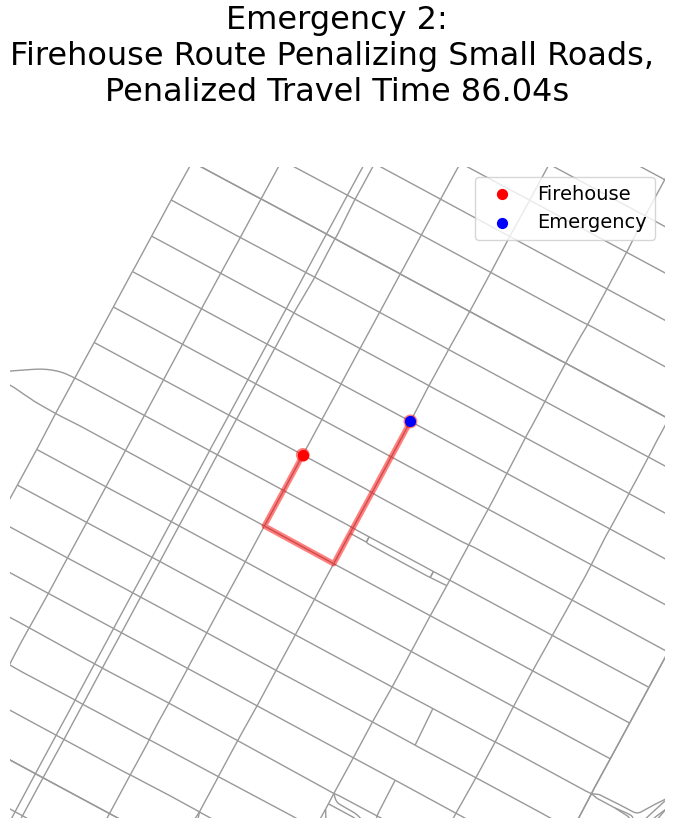

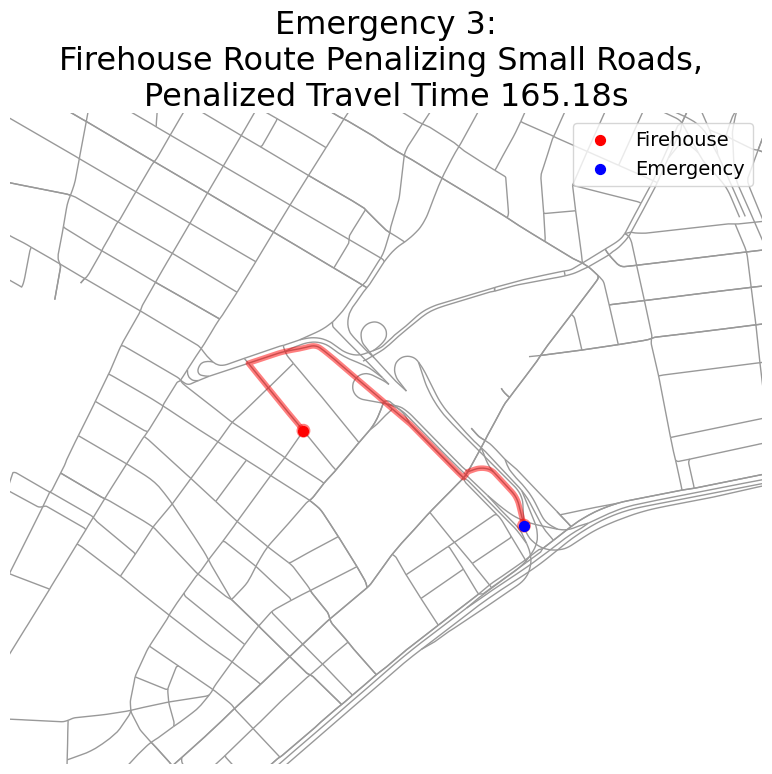

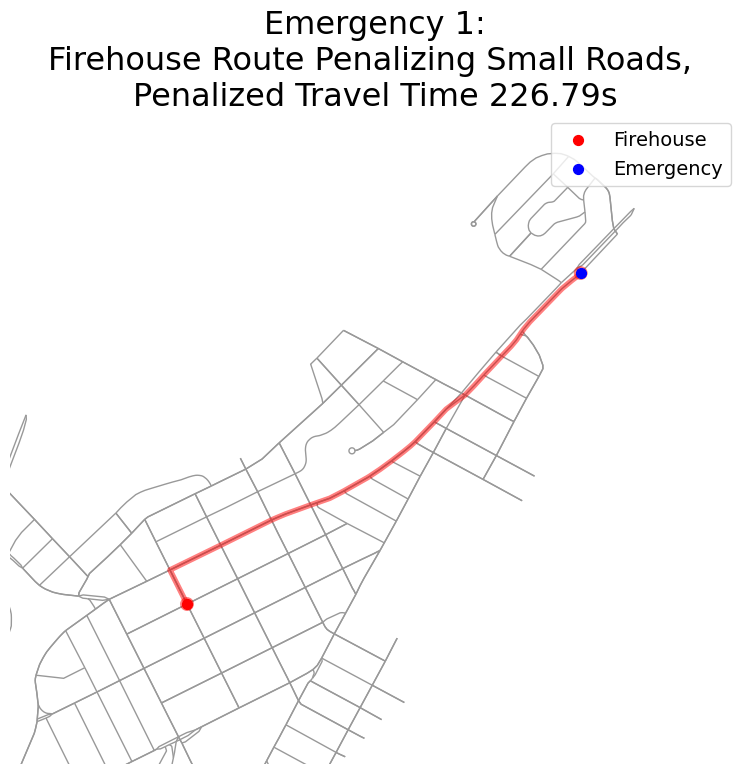

In [81]:
#Here, we do Dijkstra's algorithm to find the shortest path based on the weight which penalized small roads.
#this code is similar to the previous ones, but we use the small road weight as the weight.
small_lane_paths = []
small_lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="small_road_weight") #using small road weight here
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        small_lane_paths.append(best_path)
    if min_distance is not float("inf"):
        small_lane_distances.append(min_distance)

print(small_lane_paths)
print(small_lane_distances)

#plotting (same code as above)
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(small_lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2:\nFirehouse Route Penalizing Small Roads, \nPenalized Travel Time {round(small_lane_distances[idx], 2)}s", size = 23)

    elif idx == 1:
        ax.set_title(f"Emergency 3:\nFirehouse Route Penalizing Small Roads, \nPenalized Travel Time {round(small_lane_distances[idx], 2)}s", size = 23)
    else:
        ax.set_title(f"Emergency 1:\nFirehouse Route Penalizing Small Roads, \nPenalized Travel Time {round(small_lane_distances[idx], 2)}s", size = 23)

    ax.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()


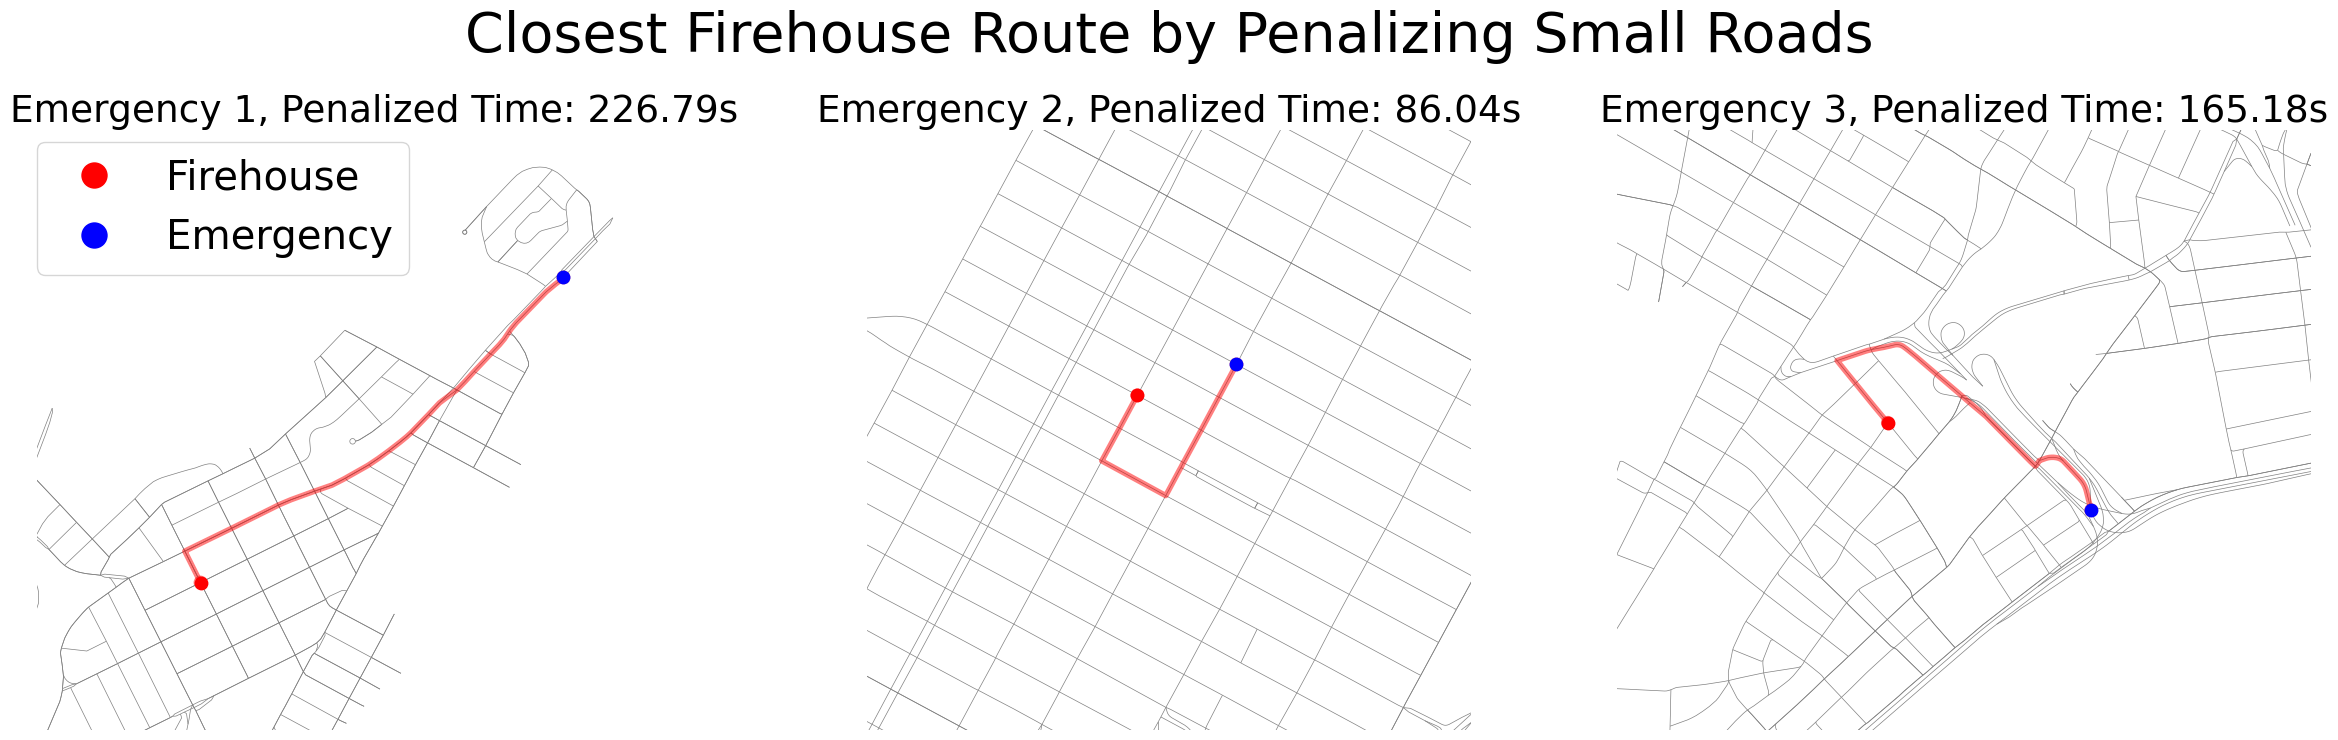

In [122]:
# Desired order: Emergency 1, Emergency 2, Emergency 3
desired_order = [2, 0, 1]  # indices in small_lane_paths

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
fig.suptitle("Closest Firehouse Route by Penalizing Small Roads", fontsize=40, y=1)

titles = [
    "Emergency 1",
    "Emergency 2",
    "Emergency 3"
]

for plot_idx, path_idx in enumerate(desired_order):
    path = small_lane_paths[path_idx]
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    ax = axes[plot_idx]

    # Plot route first so it stays on top of roads
    ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False,
        ax=ax
    )

    # Plot background road network 
    ox.plot_graph(
        G_proj,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False,
        bgcolor='white'
    )

    # Mark firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=80, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=80, zorder=3, label='Emergency')

    # Zoom to route
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"{titles[plot_idx]}, Penalized Time: {round(small_lane_distances[path_idx], 2)}s", fontsize=27)

# Shared legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Firehouse',
           markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Emergency',
           markerfacecolor='blue', markersize=20)
]

# Place the legend below the plots
fig.legend(handles=legend_handles, loc='upper left', fontsize=29, bbox_to_anchor=(0.02, 0.86))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust spacing for title and legend
plt.show()


Again, in the plot title we do not have the actual time, but time multipled by some factor (Every edge time is multiplied by a different factor)

In [61]:
#we want to count the number of different highway types in the path

for idx, path in enumerate(small_lane_paths): #looping through the paths found by using the small-road-penalized weight
    highway_counter = Counter() #initializing a counter to count the number of different highway types
    print("------")
    print(f"Highway type counts for Emergency {idx+1} path:")
    
    for u, v in zip(path[:-1], path[1:]): #pairing the nodes in the path
        edge_data = G_proj.get_edge_data(u, v) #getting edge data between u and v
        if edge_data: 
            edge = edge_data[0] if isinstance(edge_data, dict) and 0 in edge_data else edge_data #sometimes we have multiple edges between the same nodes, so we take the first one. otherwise, we just take the edge data
            highway = edge.get('highway', 'unclassified') #extracting the highway type from the edge data, and if none default to unclassified
            if isinstance(highway, list):
                highway = highway[0] #if highway is a list, take the first value
            highway_counter[highway] += 1 #updating counter

    for hghtype, count in highway_counter.items(): #printing the highway type and the count
        print(f"{hghtype}: {count}")

------
Highway type counts for Emergency 1 path:
secondary: 3
primary: 5
------
Highway type counts for Emergency 2 path:
unclassified: 1
residential: 1
secondary: 5
primary: 1
motorway_link: 2
------
Highway type counts for Emergency 3 path:
tertiary: 1
primary: 16


If we penalize large roads the most:

[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[72.11538045881555, 136.7453367203725, 265.9744896222149]


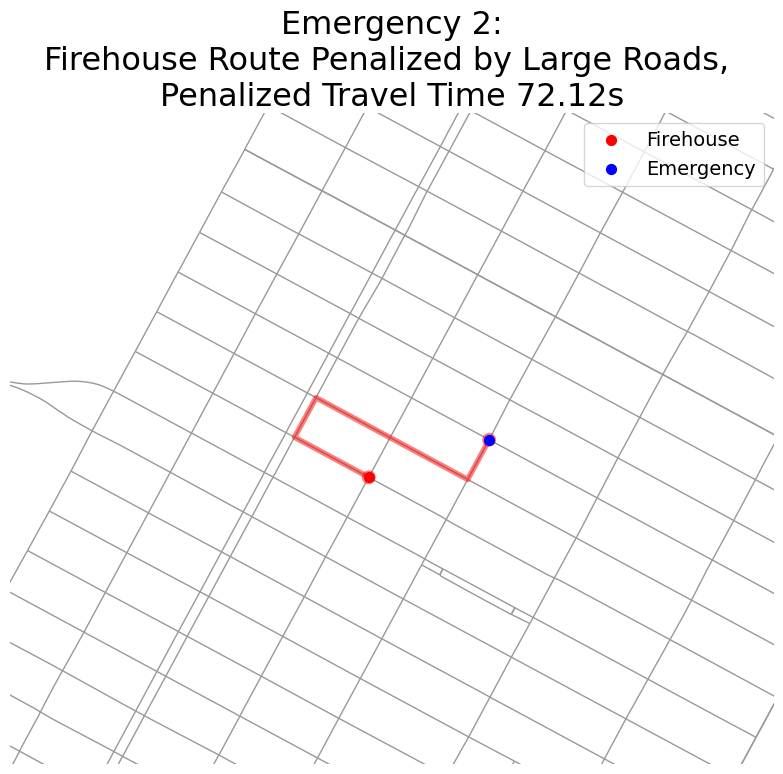

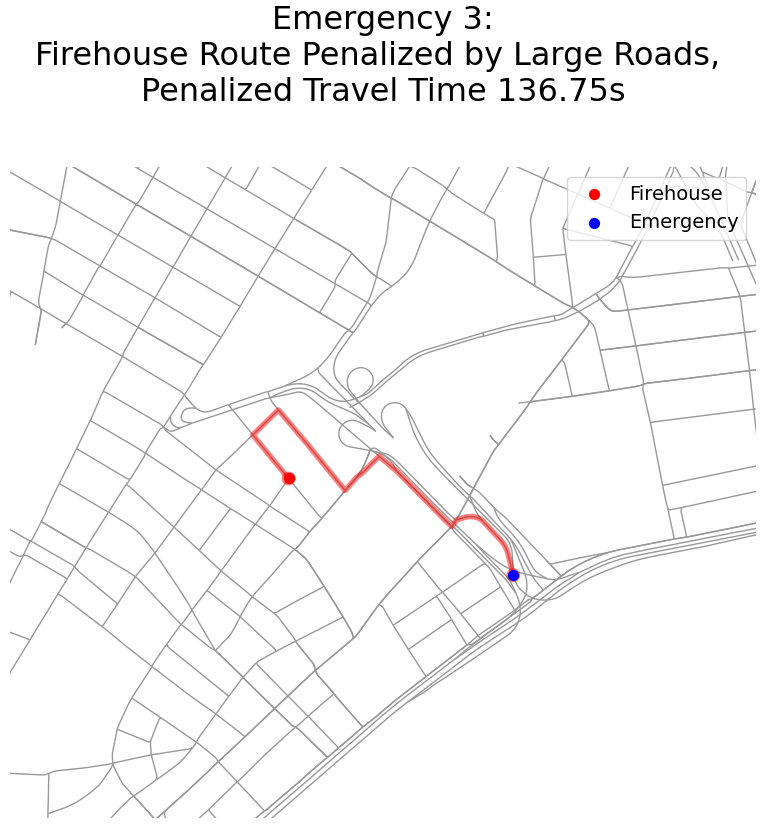

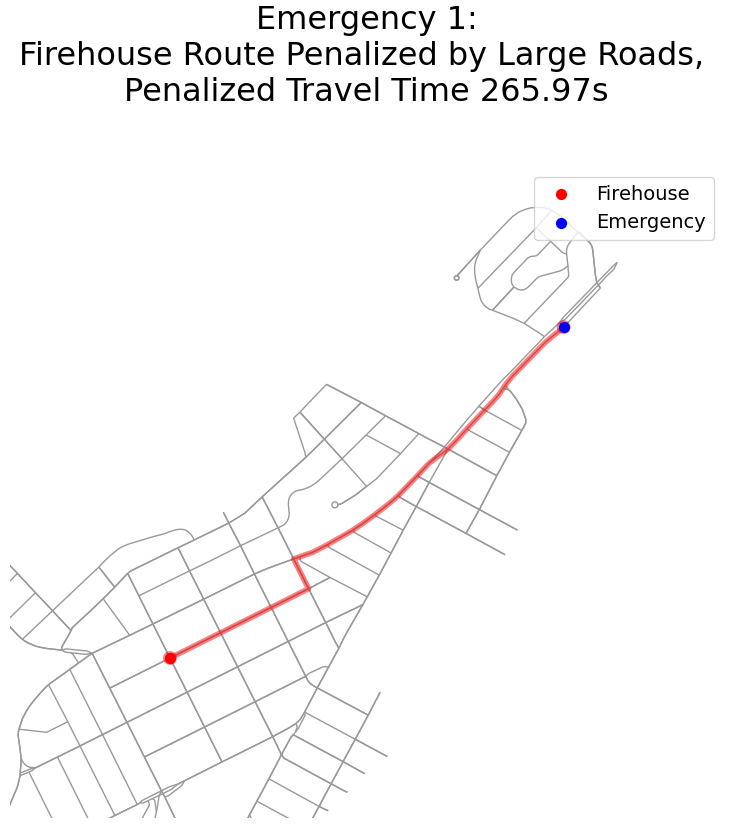

In [82]:
#repeating the same process as above, this time for the large road penalized weight
large_lane_paths = []
large_lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="large_road_weight") 
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        large_lane_paths.append(best_path)
    if min_distance is not float("inf"):
        large_lane_distances.append(min_distance)

print(large_lane_paths)
print(large_lane_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(large_lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    if idx == 0:
        ax.set_title(f"Emergency 2:\nFirehouse Route Penalized by Large Roads, \nPenalized Travel Time {round(large_lane_distances[idx], 2)}s", size = 23)

    elif idx == 1:
        ax.set_title(f"Emergency 3:\nFirehouse Route Penalized by Large Roads, \nPenalized Travel Time {round(large_lane_distances[idx], 2)}s", size = 23)
    else:
        ax.set_title(f"Emergency 1:\nFirehouse Route Penalized by Large Roads, \nPenalized Travel Time {round(large_lane_distances[idx], 2)}s", size = 23)

    ax.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()


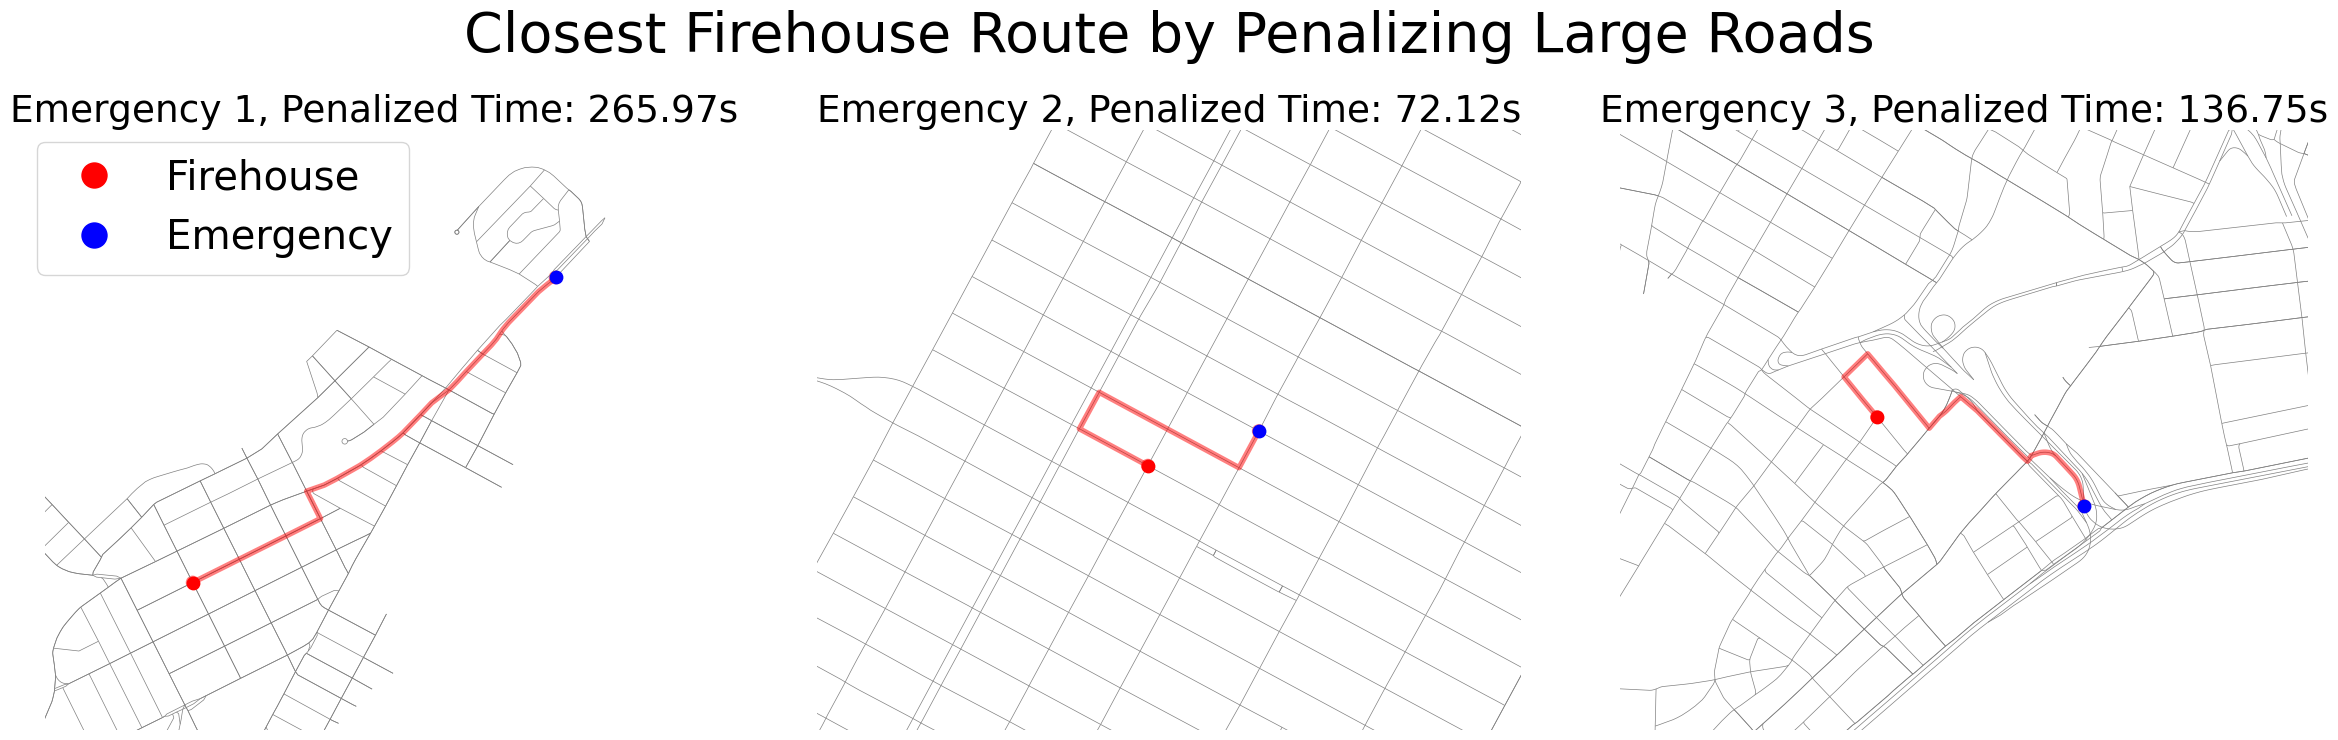

In [123]:
# Desired order: Emergency 1, Emergency 2, Emergency 3
desired_order = [2, 0, 1]  # indices in large_lane_paths

fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns
fig.suptitle("Closest Firehouse Route by Penalizing Large Roads", fontsize=40, y=1)

titles = [
    "Emergency 1",
    "Emergency 2",
    "Emergency 3"
]

for plot_idx, path_idx in enumerate(desired_order):
    path = large_lane_paths[path_idx]
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin 
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    ax = axes[plot_idx]

    # Plot route first so it stays on top of roads
    ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False,
        ax=ax
    )

    # Plot background road network 
    ox.plot_graph(
        G_proj,
        ax=ax,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.5,
        show=False,
        close=False,
        bgcolor='white'
    )

    # Mark firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=80, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=80, zorder=3, label='Emergency')

    # Zoom to route
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"{titles[plot_idx]}, Penalized Time: {round(large_lane_distances[path_idx], 2)}s", fontsize=27)

# Shared legend
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='Firehouse',
           markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Emergency',
           markerfacecolor='blue', markersize=20)
]

# Place the legend below the plots
fig.legend(handles=legend_handles, loc='upper left', fontsize=29, bbox_to_anchor=(0.02, 0.86))

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust spacing for title and legend
plt.show()


In [64]:
#similar as above, we want to count the number of different highway types in the paths. 
for idx, path in enumerate(large_lane_paths):
    highway_counter = Counter()
    print("------")
    print(f"Highway type counts for Emergency {idx+1} path:")
    
    for u, v in zip(path[:-1], path[1:]):
        edge_data = G_proj.get_edge_data(u, v)
        if edge_data:
            # Handle MultiDiGraph with multiple edges between nodes
            edge = edge_data[0] if isinstance(edge_data, dict) and 0 in edge_data else edge_data
            highway = edge.get('highway', 'unclassified')
            # Sometimes it's a list
            if isinstance(highway, list):
                highway = highway[0]
            highway_counter[highway] += 1

    for hwy_type, count in highway_counter.items():
        print(f"{hwy_type}: {count}")

------
Highway type counts for Emergency 1 path:
residential: 3
primary: 2
------
Highway type counts for Emergency 2 path:
unclassified: 1
residential: 4
secondary: 2
primary: 1
motorway_link: 2
------
Highway type counts for Emergency 3 path:
tertiary: 4
primary: 13


# ADDITIONAL MATERIAL:

## Degree Centrality

One of the things we can explore is the degree centrality of nodes, and create a weight that penalizes whether an edge is connected to nodes with high degree centrality (in high traffic, this means that the edge is connected to a large intersection and therefore is more likely to be stuck in traffic jams)

In [65]:
#first, we create a function that computes the degree centrality and assigns it to the nodes
def assign_node_degree_centrality(G):
    """
    Computes degree centrality and assigns it as a node attribute in the graph.
    """
    centrality = nx.degree_centrality(G)
    nx.set_node_attributes(G, centrality, "degree_centrality")
    return G

#now, we define a function that returns the penalized weight of an edge.
def penalize_by_node_degree(data, u, v, G, centrality_penalty_factor=10):
    """
    Computes edge weight using length or default travel time, and penalizes it if the edge connects to high degree centrality nodes.
    The centrality penalty is the factor by which we want to penalize the travel time.
    """
    try:
        if G is None or u is None or v is None:
            raise ValueError("penalize_by_node_degree requires G, u, and v.")

        #the base weight is going to be the road length
        length = data.get('length', 1) #defaults to 1 if the length is missing

        #accessing the degree centrality of the nodes
        u_centrality = G.nodes[u].get("degree_centrality", 0)
        v_centrality = G.nodes[v].get("degree_centrality", 0)

        penalty = centrality_penalty_factor * max(u_centrality, v_centrality) #takes the maximum centrality of the two nodes (since an edge is connected to two nodes)
        return length * (1 + penalty) #add 1 so we aren't multiplying by 0.something and downscaling the weight

    except Exception as e:
        print(f"Error computing centrality-penalized weight for edge ({u}, {v}): {e}")
        return float("inf")

In [67]:
G_proj = assign_node_degree_centrality(G_proj)

for u, v, data in G_proj.edges(data=True):
    data["centrality_penalized_weight"] = penalize_by_node_degree(data, u=u, v=v, G=G_proj)

[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[614.1056904906494, 927.9115038529587, 1735.7532489291912]


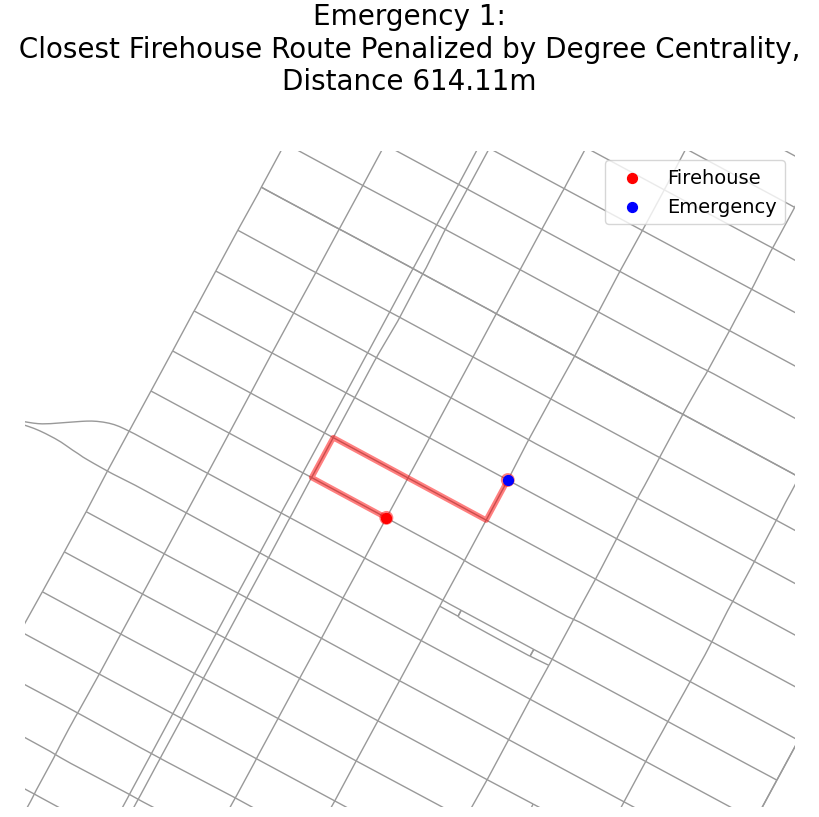

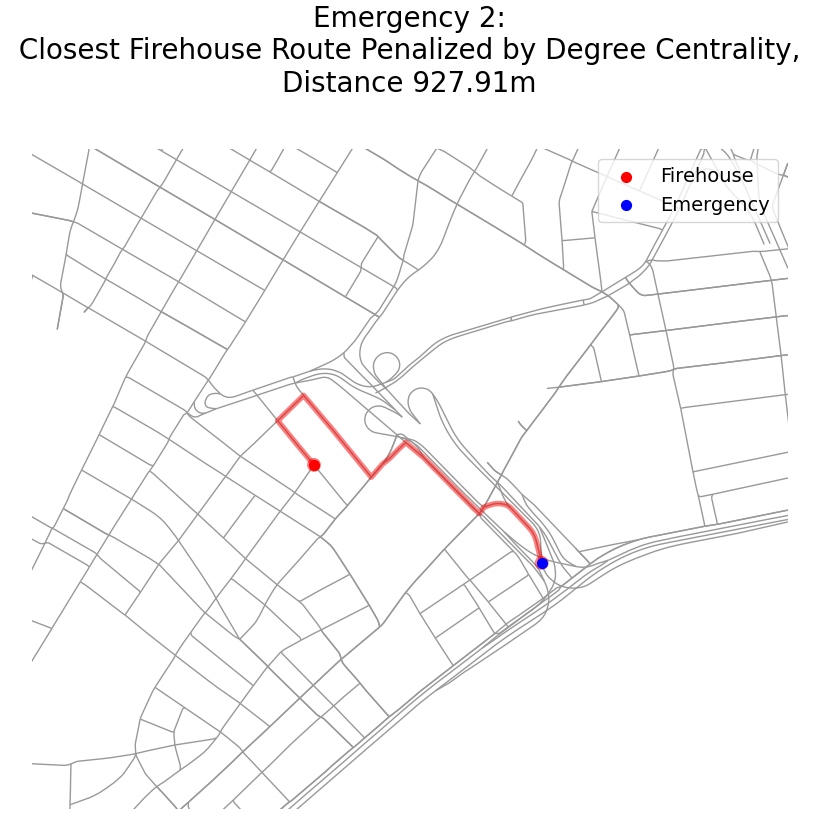

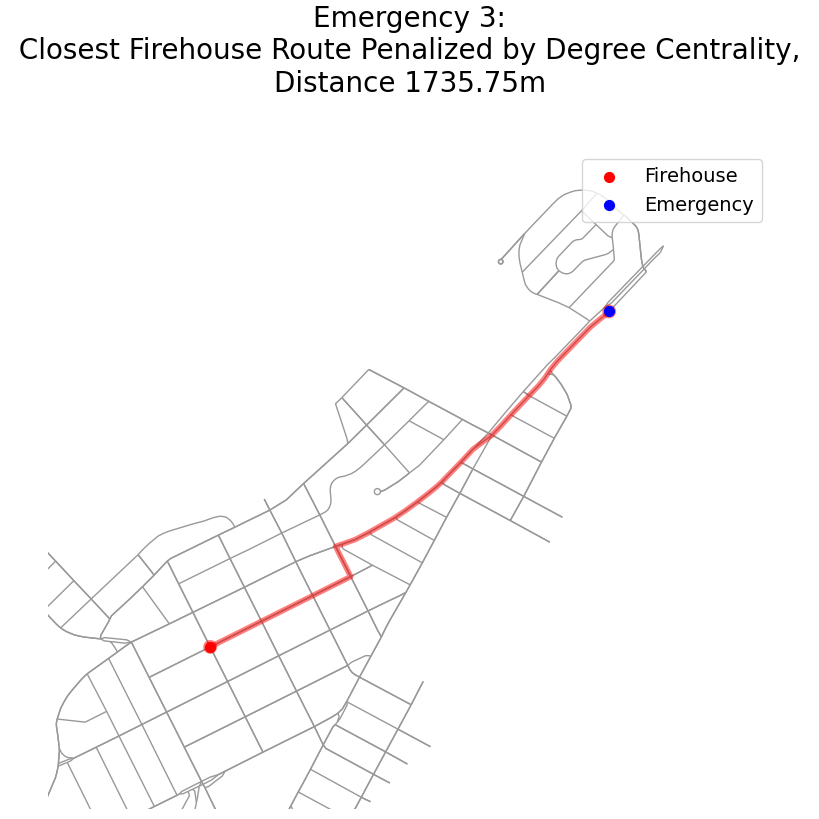

In [68]:
#now, we use dijkstra's algorithm using the centrality penalized weights
lane_paths = []
lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="centrality_penalized_weight") 
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        lane_paths.append(best_path)
    if min_distance is not float("inf"):
        lane_distances.append(min_distance)

print(lane_paths)
print(lane_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}:\n Closest Firehouse Route Penalized by Degree Centrality, \nDistance {round(lane_distances[idx], 2)}m", size = 20)
    ax.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()


In [72]:
#computing the average degree centrality of each route, and seeing if it is higher than the average of the whole graph
import numpy as np

pathcentralities = []
for idx, path in enumerate(lane_paths):
    print(f"Path {idx+1} (Firehouse {path[0]} to Emergency {path[-1]}):")
    centrality_values = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        edge_data = G_proj.get_edge_data(u, v)

        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]

        centrality = G_proj.nodes[u].get("degree_centrality", "N/A")
        print(f"  Edge ({u}, {v}) Degree Centrality: {centrality}")
        centrality_values.append(centrality)
    
    avg_centrality = sum(centrality_values) / len(centrality_values)
    print(f"Average Degree Centrality of Path {idx+1}: {avg_centrality}")
    pathcentralities.append(avg_centrality)
    print()
    
#computing the average degree centrality of the whole graph
#this is done by taking the average of the degree centrality of all nodes
degree_centrality_values = [data["degree_centrality"] for _, data in G_proj.nodes(data=True)]
average_centrality = sum(degree_centrality_values) / len(degree_centrality_values)
print(f"Average Degree Centrality of the Graph: {average_centrality}")

print(pathcentralities)
print(np.array(pathcentralities) < average_centrality)  #we would ideally have true if the paths actually avoid high degree centrality nodes

Path 1 (Firehouse 42437433 to Emergency 42449991):
  Edge (42437433, 42437428) Degree Centrality: 0.0008684324793747286
  Edge (42437428, 42431677) Degree Centrality: 0.0008684324793747286
  Edge (42431677, 42431678) Degree Centrality: 0.0008684324793747286
  Edge (42431678, 42431680) Degree Centrality: 0.0008684324793747286
  Edge (42431680, 42449991) Degree Centrality: 0.0008684324793747286
Average Degree Centrality of Path 1: 0.0008684324793747286

Path 2 (Firehouse 42448593 to Emergency 278608718):
  Edge (42448593, 42456492) Degree Centrality: 0.0006513243595310464
  Edge (42456492, 42427236) Degree Centrality: 0.0008684324793747286
  Edge (42427236, 42427242) Degree Centrality: 0.0006513243595310464
  Edge (42427242, 42459820) Degree Centrality: 0.0010855405992184109
  Edge (42459820, 42448483) Degree Centrality: 0.0010855405992184109
  Edge (42448483, 4158673495) Degree Centrality: 0.0006513243595310464
  Edge (4158673495, 42422283) Degree Centrality: 0.0008684324793747286
  Edg

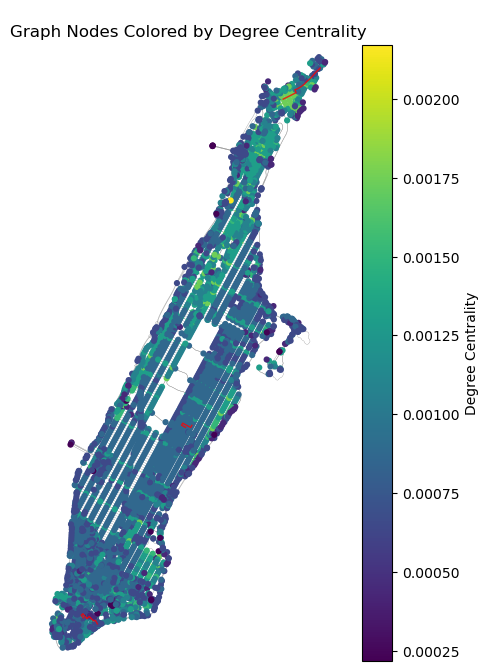

In [71]:
#getting node centrality values for coloring
node_centralities = nx.get_node_attributes(G_proj, "degree_centrality")
node_colors = [node_centralities.get(n, 0) for n in G_proj.nodes()]

#drawing the graph
fig, ax = ox.plot_graph(
    G_proj,
    node_color=node_colors,
    node_size=20,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="gray",
    bgcolor='white',
    show=False,
    close=False
)

#adding a colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Degree Centrality")
plt.title("Graph Nodes Colored by Degree Centrality")

for path in lane_paths:
    path_x = [G_proj.nodes[n]['x'] for n in path]
    path_y = [G_proj.nodes[n]['y'] for n in path]
    ax.plot(path_x, path_y, color='red', linewidth=1, alpha=0.8, zorder=3)

plt.show()

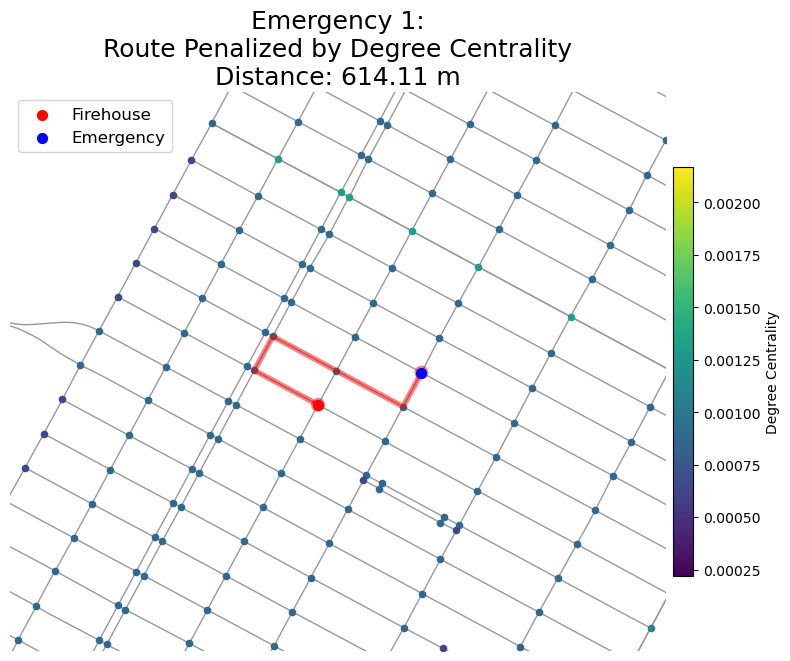

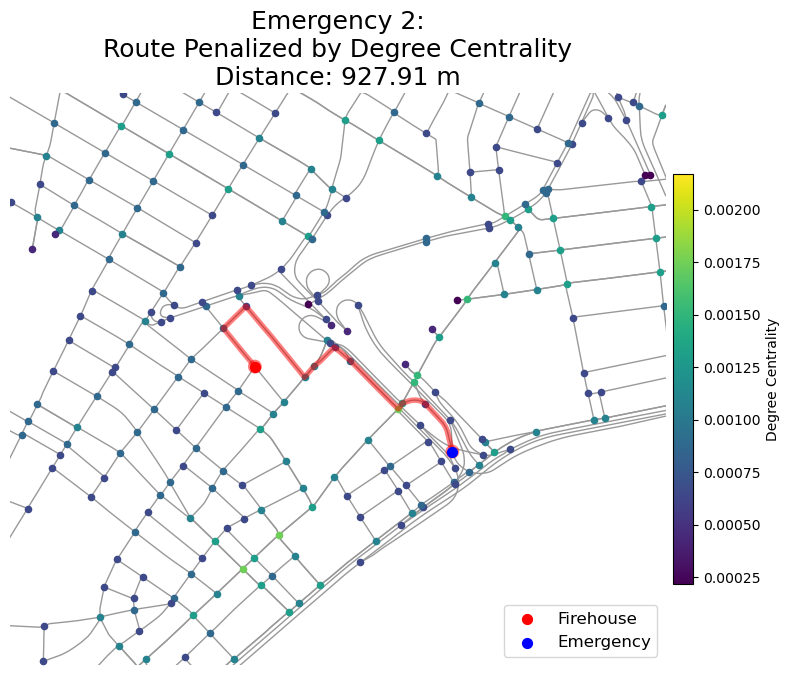

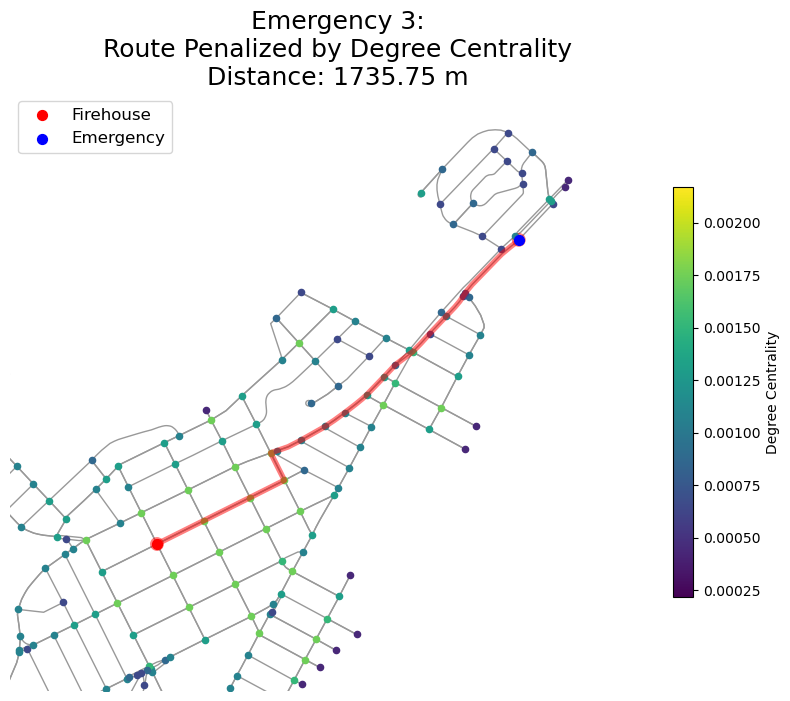

In [74]:
import matplotlib.cm as cm
import matplotlib.colors as colors

#getting node centrality values
node_centralities = nx.get_node_attributes(G_proj, "degree_centrality")
vmin, vmax = min(node_centralities.values()), max(node_centralities.values())
cmap = cm.viridis
norm = colors.Normalize(vmin=vmin, vmax=vmax)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    #plotting the base graph and path
    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )

    #drawing all nodes in the zoomed-in area, colored by centrality
    for node in G_proj.nodes:
        x, y = node_positions[node]
        if minx <= x <= maxx and miny <= y <= maxy:
            centrality = node_centralities.get(node, 0)
            ax.scatter(x, y, c=[cmap(norm(centrality))], s=20, zorder=1)

    #highlighting firehouse and emergency
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}:\nRoute Penalized by Degree Centrality\nDistance: {round(lane_distances[idx], 2)} m", size=18)
    ax.legend(fontsize=12)

    #adding colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
    cbar.set_label("Degree Centrality")

    plt.tight_layout()
    plt.show()



## Seeing Basic Street Network Stats

Here, we just observe some general properties of the street network we have.

In [75]:
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
print(graph_area_m)
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

85331687.57542239


{'n': 4607,
 'm': 9888,
 'k_avg': 4.2925982200998485,
 'edge_length_total': 1175594.7197782712,
 'edge_length_avg': 118.89105175751124,
 'streets_per_node_avg': 3.5519861080963753,
 'streets_per_node_counts': {0: 0, 1: 102, 2: 28, 3: 1768, 4: 2643, 5: 66},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.02214022140221402,
  2: 0.006077707835901888,
  3: 0.3837638376383764,
  4: 0.5736922075103104,
  5: 0.014326025613197308},
 'intersection_count': 4505,
 'street_length_total': 992241.1003086723,
 'street_segment_count': 8168,
 'street_length_avg': 121.4790769231969,
 'circuity_avg': 1.0203187196387995,
 'self_loop_proportion': 0.0009794319294809011,
 'clean_intersection_count': 3645,
 'node_density_km': 53.98932250024935,
 'intersection_density_km': 52.79398694673829,
 'edge_density_km': 13776.766324223865,
 'street_density_km': 11628.049655430252,
 'clean_intersection_density_km': 42.71566757399802}